In [1]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions.normal import Normal
import torch.nn.functional as F
import gc
import imutils
import math

import data
import models
from models import *

/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:3"
LATENT_DIM = 64
NUM_GENERATORS = 3
ALPHA = 3

In [56]:
# We will work with the distilled data for the sake of simplicity of our work, it turns out that the distilled dataset contains only 0s and 1s

In [5]:
X_train, X_test, Y_train, Y_test = data.get_dataset_augmented()

train_dataset = TensorDataset(X_train,Y_train)
train_dataloader = DataLoader(train_dataset,
                              batch_size=512,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

test_dataset = TensorDataset(X_test,Y_test)
test_dataloader = DataLoader(test_dataset,
                              batch_size=512,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

model_VAE = torch.load("../symmetry_2/VAE.pt")
model_VAE = model_VAE.to(device)

In [6]:
model_VAE.eval()
train_Z = model_VAE.fc2(model_VAE.fc_mu(model_VAE.encoder(X_train.to(device)))).cpu().detach()
test_Z = model_VAE.fc2(model_VAE.fc_mu(model_VAE.encoder(X_test.to(device)))).cpu().detach()

train_dataset_Z = TensorDataset(train_Z,Y_train)
train_dataloader_Z = DataLoader(train_dataset_Z,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

test_dataset_Z = TensorDataset(test_Z,Y_test)
test_dataloader_Z = DataLoader(test_dataset_Z,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

In [10]:
model_fe = models.MLP(feature_size=LATENT_DIM).to(device)
model_fd = models.MLP(feature_size=LATENT_DIM).to(device)
# model_fo = models.LatentOracle().to(device)
model_fo = models.LatentOracle().to(device)

model_symmetry = models.GroupLatent(num_features=LATENT_DIM,num_generators=NUM_GENERATORS).to(device)

optimiser_fe = torch.optim.Adam(model_fe.parameters(), lr = 1e-3)
optimiser_fd = torch.optim.Adam(model_fd.parameters(), lr = 1e-3)
optimiser_fo = torch.optim.Adam(model_fo.parameters(), lr = 1e-3)
optimiser_symmetry = torch.optim.Adam(model_symmetry.parameters(), lr = 1e-3)


criterion_mse = nn.MSELoss()
criterion_BCE = nn.BCEWithLogitsLoss()
criterion_entropy = nn.CrossEntropyLoss(reduction = 'none')

/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [11]:
loss_S_closure = []
loss_S_orth = []
loss_S_collapse = []

loss_space = []
loss_oracle = []
for i in range(300):
    
    loss_S_closure_ = 0
    loss_S_orth_ = 0
    loss_S_collapse_ = 0

    loss_space_ = 0
    loss_oracle_ = 0
    
    for Z,M in tqdm(train_dataloader_Z):
        Z = Z.to(device)
        M = M.type(torch.LongTensor).to(device)
        
        optimiser_fd.zero_grad()
        optimiser_fe.zero_grad()
        optimiser_fo.zero_grad()
        optimiser_symmetry.zero_grad()

        theta = [(2*torch.rand(Z.shape[0],device = device) - 1) for i in range(NUM_GENERATORS)]  #Sampling

        P = model_fe(Z)
        P_S = model_symmetry(theta = theta, x = P)
        Z_S = model_fd(P_S)
        m = model_fo(Z)
        m_S = model_fo(Z_S)
        Z_P = model_fd(P)

        loss1 = criterion_entropy(m_S,torch.argmax(torch.softmax(m,-1), -1))
        loss2 = model_symmetry.orthogonal_loss()
        loss3 = model_symmetry.collapse_loss()
        loss5 = criterion_mse(Z,Z_P)
        loss6 = criterion_entropy(m.squeeze(),M)
        
        loss_S = torch.mean(loss1*torch.exp(-ALPHA*loss6)) + loss2 + loss3
        # loss_Ae = loss5
        loss_Ae = loss5 + torch.mean(loss1*torch.exp(-ALPHA*loss6)) # Testing ...
        loss_O = torch.mean(loss6)
        
        loss_S.backward(retain_graph=True)
        loss_Ae.backward(retain_graph=True)
        loss_O.backward(retain_graph=True)
        
        
        
        optimiser_fd.step()
        optimiser_fe.step()
        optimiser_fo.step()
        optimiser_symmetry.step()
    
        
        loss_S_closure_ += torch.mean(loss1*torch.exp(-ALPHA*loss6)).item()
        try:
            loss_S_orth_ += loss2.item()
        except AttributeError:
            loss_S_orth_ = 0

        loss_S_collapse_ += loss3.item()

        loss_space_ += loss5.item()
        loss_oracle_ += loss_O.item()
    
    loss_S_closure_ /= len(train_dataloader)
    loss_S_orth_ /= len(train_dataloader)
    loss_S_collapse_ /= len(train_dataloader)

    loss_space_ /= len(train_dataloader)
    loss_oracle_ /= len(train_dataloader)
    
    
    loss_S_closure.append(loss_S_closure_)
    loss_S_collapse.append(loss_S_collapse_)
    loss_S_orth.append(loss_S_orth_)
    
    loss_space.append(loss_space_)
    loss_oracle.append(loss_oracle_)
    
    print(f"EPOCH {i} complete")
    print("=====================")
    print("Symmetry Closure Loss ",loss_S_closure_)
    print("Symmetry Orthogonality Loss ",loss_S_orth_)
    print("Symmetry Collapse Loss ",loss_S_collapse_)
    
    print("Space Inversion Loss ",loss_space_)
    print("Oracle loss",loss_oracle_)
    print("=====================")
    

100%|██████████| 166/166 [00:03<00:00, 42.40it/s]


EPOCH 0 complete
Symmetry Closure Loss  0.0020046581171245417
Symmetry Orthogonality Loss  0.0026282925640530213
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.020980826606735566
Oracle loss 0.22239606001649995


100%|██████████| 166/166 [00:03<00:00, 44.26it/s]


EPOCH 1 complete
Symmetry Closure Loss  0.002718018360873572
Symmetry Orthogonality Loss  0.0007553165767998267
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005127337578184768
Oracle loss 0.17969723431819892


100%|██████████| 166/166 [00:03<00:00, 44.98it/s]


EPOCH 2 complete
Symmetry Closure Loss  0.0027593232548223383
Symmetry Orthogonality Loss  0.0007319098053758133
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00042587418126009674
Oracle loss 0.15659800809190935


100%|██████████| 166/166 [00:03<00:00, 44.49it/s]


EPOCH 3 complete
Symmetry Closure Loss  0.002854791635378118
Symmetry Orthogonality Loss  0.0007220989633884551
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00053574543983496
Oracle loss 0.13926671580018768


100%|██████████| 166/166 [00:03<00:00, 45.07it/s]


EPOCH 4 complete
Symmetry Closure Loss  0.0026773825127923167
Symmetry Orthogonality Loss  0.0007053578801239919
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006248977561958179
Oracle loss 0.12697109539645263


100%|██████████| 166/166 [00:03<00:00, 46.48it/s]


EPOCH 5 complete
Symmetry Closure Loss  0.0025559775657525443
Symmetry Orthogonality Loss  0.0007272737731186516
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006204680714991886
Oracle loss 0.11857582781329212


100%|██████████| 166/166 [00:03<00:00, 43.09it/s]


EPOCH 6 complete
Symmetry Closure Loss  0.0024914550300440693
Symmetry Orthogonality Loss  0.0007058948559647269
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006275998420749668
Oracle loss 0.11270431909395988


100%|██████████| 166/166 [00:03<00:00, 47.43it/s]


EPOCH 7 complete
Symmetry Closure Loss  0.0024343767113624566
Symmetry Orthogonality Loss  0.0007030806039229978
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006508931197809527
Oracle loss 0.10845478906868453


100%|██████████| 166/166 [00:03<00:00, 46.02it/s]


EPOCH 8 complete
Symmetry Closure Loss  0.002331333333087793
Symmetry Orthogonality Loss  0.0006968699064644346
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006604159776126988
Oracle loss 0.1053178734538785


100%|██████████| 166/166 [00:03<00:00, 47.13it/s]


EPOCH 9 complete
Symmetry Closure Loss  0.002264830617638058
Symmetry Orthogonality Loss  0.0006960968501691943
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006916703591796469
Oracle loss 0.10279210894761315


100%|██████████| 166/166 [00:03<00:00, 43.86it/s]


EPOCH 10 complete
Symmetry Closure Loss  0.002190523055741137
Symmetry Orthogonality Loss  0.0007047715340179941
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006977511855285525
Oracle loss 0.10079957167786288


100%|██████████| 166/166 [00:03<00:00, 45.92it/s]


EPOCH 11 complete
Symmetry Closure Loss  0.002122401255631752
Symmetry Orthogonality Loss  0.0006991126294057053
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006910061904829534
Oracle loss 0.09922037933425731


100%|██████████| 166/166 [00:03<00:00, 42.43it/s]


EPOCH 12 complete
Symmetry Closure Loss  0.0020626107530937678
Symmetry Orthogonality Loss  0.0007033235665567847
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006608047869045243
Oracle loss 0.09793064949742283


100%|██████████| 166/166 [00:03<00:00, 47.06it/s]


EPOCH 13 complete
Symmetry Closure Loss  0.0020159045080037183
Symmetry Orthogonality Loss  0.0006948341555887811
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006422946967341634
Oracle loss 0.09691739948578627


100%|██████████| 166/166 [00:03<00:00, 46.33it/s]


EPOCH 14 complete
Symmetry Closure Loss  0.0020042444503563174
Symmetry Orthogonality Loss  0.0006916414254137416
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006423406664096941
Oracle loss 0.09603082343756435


100%|██████████| 166/166 [00:03<00:00, 47.01it/s]


EPOCH 15 complete
Symmetry Closure Loss  0.0019539780613225715
Symmetry Orthogonality Loss  0.0006893084490396846
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006273178189448698
Oracle loss 0.09530084625066045


100%|██████████| 166/166 [00:03<00:00, 43.58it/s]


EPOCH 16 complete
Symmetry Closure Loss  0.001907131401821971
Symmetry Orthogonality Loss  0.0006872467673523912
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00061599250443852
Oracle loss 0.09466006081685963


100%|██████████| 166/166 [00:03<00:00, 43.71it/s]


EPOCH 17 complete
Symmetry Closure Loss  0.0018694748960334405
Symmetry Orthogonality Loss  0.0006798067219914442
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006116639296047345
Oracle loss 0.09408751529562905


100%|██████████| 166/166 [00:03<00:00, 45.40it/s]


EPOCH 18 complete
Symmetry Closure Loss  0.0018211544122468367
Symmetry Orthogonality Loss  0.0006870525844916925
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006069916090787759
Oracle loss 0.09360214318317103


100%|██████████| 166/166 [00:03<00:00, 47.16it/s]


EPOCH 19 complete
Symmetry Closure Loss  0.00181004103253517
Symmetry Orthogonality Loss  0.0006840071067247674
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006102160768056041
Oracle loss 0.09311478867767806


100%|██████████| 166/166 [00:03<00:00, 47.52it/s]


EPOCH 20 complete
Symmetry Closure Loss  0.0017566474460357104
Symmetry Orthogonality Loss  0.0006651801280873682
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006126833747208388
Oracle loss 0.09272355002811156


100%|██████████| 166/166 [00:03<00:00, 46.64it/s]


EPOCH 21 complete
Symmetry Closure Loss  0.0017191447508353066
Symmetry Orthogonality Loss  0.0006578095441022102
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000610723259440814
Oracle loss 0.09232152100787105


100%|██████████| 166/166 [00:03<00:00, 44.87it/s]


EPOCH 22 complete
Symmetry Closure Loss  0.0016850088807159518
Symmetry Orthogonality Loss  0.0006558215883784894
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006118696575692619
Oracle loss 0.09199637749108923


100%|██████████| 166/166 [00:04<00:00, 39.73it/s]


EPOCH 23 complete
Symmetry Closure Loss  0.0016595160901400608
Symmetry Orthogonality Loss  0.0006464710616904972
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006114837246475719
Oracle loss 0.0916436280920563


100%|██████████| 166/166 [00:03<00:00, 46.44it/s]


EPOCH 24 complete
Symmetry Closure Loss  0.0016068088189496782
Symmetry Orthogonality Loss  0.0006493025021739753
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006033666635280004
Oracle loss 0.0913149416895516


100%|██████████| 166/166 [00:03<00:00, 45.09it/s]


EPOCH 25 complete
Symmetry Closure Loss  0.00155661449661052
Symmetry Orthogonality Loss  0.0006487900875116059
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006001016825678792
Oracle loss 0.09106163716459849


100%|██████████| 166/166 [00:03<00:00, 45.19it/s]


EPOCH 26 complete
Symmetry Closure Loss  0.001523515884904752
Symmetry Orthogonality Loss  0.0006596042938721198
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006032530253427664
Oracle loss 0.0908160468630762


100%|██████████| 166/166 [00:03<00:00, 45.51it/s]


EPOCH 27 complete
Symmetry Closure Loss  0.001494157742372299
Symmetry Orthogonality Loss  0.0006343963119784841
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006047228844948562
Oracle loss 0.09058667346835136


100%|██████████| 166/166 [00:03<00:00, 47.25it/s]


EPOCH 28 complete
Symmetry Closure Loss  0.0014746869761350912
Symmetry Orthogonality Loss  0.000644246516721211
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006112435328387039
Oracle loss 0.09030815900628825


100%|██████████| 166/166 [00:03<00:00, 44.07it/s]


EPOCH 29 complete
Symmetry Closure Loss  0.0014329793777440238
Symmetry Orthogonality Loss  0.0006396867589413537
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005908407010025827
Oracle loss 0.09005704028419702


100%|██████████| 166/166 [00:03<00:00, 47.73it/s]


EPOCH 30 complete
Symmetry Closure Loss  0.0014182372111266098
Symmetry Orthogonality Loss  0.0006386628132509853
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005800519450651819
Oracle loss 0.08988154993717928


100%|██████████| 166/166 [00:03<00:00, 46.85it/s]


EPOCH 31 complete
Symmetry Closure Loss  0.0013813313632552702
Symmetry Orthogonality Loss  0.0006310280050566218
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005821927611194327
Oracle loss 0.08966425164456827


100%|██████████| 166/166 [00:03<00:00, 46.47it/s]


EPOCH 32 complete
Symmetry Closure Loss  0.0013477564200265221
Symmetry Orthogonality Loss  0.0006325518542687487
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000552412446487291
Oracle loss 0.08943294985107629


100%|██████████| 166/166 [00:03<00:00, 46.92it/s]


EPOCH 33 complete
Symmetry Closure Loss  0.0013466761538657888
Symmetry Orthogonality Loss  0.0006451769861678806
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000556069297901164
Oracle loss 0.0892942439630089


100%|██████████| 166/166 [00:03<00:00, 47.02it/s]


EPOCH 34 complete
Symmetry Closure Loss  0.0013299908170599985
Symmetry Orthogonality Loss  0.000637700821200094
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00053805154741248
Oracle loss 0.08913362192281757


100%|██████████| 166/166 [00:03<00:00, 42.27it/s]


EPOCH 35 complete
Symmetry Closure Loss  0.0013474543433052947
Symmetry Orthogonality Loss  0.0006200784792091293
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005499247644946585
Oracle loss 0.08901131952024367


100%|██████████| 166/166 [00:03<00:00, 46.16it/s]


EPOCH 36 complete
Symmetry Closure Loss  0.001331354041881186
Symmetry Orthogonality Loss  0.0006175634212068181
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005438015280790761
Oracle loss 0.08890128194029073


100%|██████████| 166/166 [00:03<00:00, 47.47it/s]


EPOCH 37 complete
Symmetry Closure Loss  0.001289962835088148
Symmetry Orthogonality Loss  0.0006141582520044667
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000531719160527103
Oracle loss 0.08872455542525613


100%|██████████| 166/166 [00:03<00:00, 45.52it/s]


EPOCH 38 complete
Symmetry Closure Loss  0.0012630955940280783
Symmetry Orthogonality Loss  0.000625782767212557
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005133288824111672
Oracle loss 0.0885998377778444


100%|██████████| 166/166 [00:03<00:00, 47.72it/s]


EPOCH 39 complete
Symmetry Closure Loss  0.0012606678920495044
Symmetry Orthogonality Loss  0.0006150757120389222
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005144168772168053
Oracle loss 0.08851609783000257


100%|██████████| 166/166 [00:03<00:00, 47.04it/s]


EPOCH 40 complete
Symmetry Closure Loss  0.0012516233598790973
Symmetry Orthogonality Loss  0.000611968356372609
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005160370530947728
Oracle loss 0.08839584532451916


100%|██████████| 166/166 [00:03<00:00, 46.41it/s]


EPOCH 41 complete
Symmetry Closure Loss  0.0012487273372945387
Symmetry Orthogonality Loss  0.0005926182770579829
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004993382182480004
Oracle loss 0.08831277337059917


100%|██████████| 166/166 [00:03<00:00, 45.04it/s]


EPOCH 42 complete
Symmetry Closure Loss  0.0012719441985105534
Symmetry Orthogonality Loss  0.000595298284350569
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005252357978718804
Oracle loss 0.08825316069176398


100%|██████████| 166/166 [00:03<00:00, 47.57it/s]


EPOCH 43 complete
Symmetry Closure Loss  0.001244547000541969
Symmetry Orthogonality Loss  0.0006092060343306288
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000501435750594688
Oracle loss 0.08812571348375585


100%|██████████| 166/166 [00:03<00:00, 44.54it/s]


EPOCH 44 complete
Symmetry Closure Loss  0.001173519376519484
Symmetry Orthogonality Loss  0.0005940408007584019
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004752964657627562
Oracle loss 0.08800701473850801


100%|██████████| 166/166 [00:03<00:00, 45.37it/s]


EPOCH 45 complete
Symmetry Closure Loss  0.001161803178635078
Symmetry Orthogonality Loss  0.0006007339054275394
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004572808523017195
Oracle loss 0.08790921711598534


100%|██████████| 166/166 [00:03<00:00, 47.34it/s]


EPOCH 46 complete
Symmetry Closure Loss  0.0011791589344481387
Symmetry Orthogonality Loss  0.000594508596092844
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004733449070088857
Oracle loss 0.08788768623966768


100%|██████████| 166/166 [00:03<00:00, 47.65it/s]


EPOCH 47 complete
Symmetry Closure Loss  0.001154059176725975
Symmetry Orthogonality Loss  0.0006177365900499813
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00046036587761580405
Oracle loss 0.08779358688786805


100%|██████████| 166/166 [00:03<00:00, 48.40it/s]


EPOCH 48 complete
Symmetry Closure Loss  0.0011422867158775677
Symmetry Orthogonality Loss  0.000588667498346059
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004562137906891238
Oracle loss 0.08772680217243102


100%|██████████| 166/166 [00:03<00:00, 46.66it/s]


EPOCH 49 complete
Symmetry Closure Loss  0.001118182045819956
Symmetry Orthogonality Loss  0.0006022211374625204
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00045361536108265936
Oracle loss 0.08770078824586179


100%|██████████| 166/166 [00:03<00:00, 47.24it/s]


EPOCH 50 complete
Symmetry Closure Loss  0.001126708615015833
Symmetry Orthogonality Loss  0.0005960555351619799
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00045009673480505505
Oracle loss 0.08759474283061831


100%|██████████| 166/166 [00:03<00:00, 48.84it/s]


EPOCH 51 complete
Symmetry Closure Loss  0.0011063578064519778
Symmetry Orthogonality Loss  0.0005618567450157176
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004387895910823942
Oracle loss 0.08750411939908223


100%|██████████| 166/166 [00:03<00:00, 45.28it/s]


EPOCH 52 complete
Symmetry Closure Loss  0.0010865224989591144
Symmetry Orthogonality Loss  0.0005738323562110897
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004296981912254951
Oracle loss 0.08750117350235043


100%|██████████| 166/166 [00:03<00:00, 47.91it/s]


EPOCH 53 complete
Symmetry Closure Loss  0.0010808163707520455
Symmetry Orthogonality Loss  0.0005738685575190438
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00042629293804281355
Oracle loss 0.08741744953286217


100%|██████████| 166/166 [00:03<00:00, 45.30it/s]


EPOCH 54 complete
Symmetry Closure Loss  0.0010530704917128097
Symmetry Orthogonality Loss  0.0005714951433011342
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004171791675091014
Oracle loss 0.08731907386198101


100%|██████████| 166/166 [00:03<00:00, 46.95it/s]


EPOCH 55 complete
Symmetry Closure Loss  0.0010809228339664504
Symmetry Orthogonality Loss  0.0005663069756140551
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004286226972163352
Oracle loss 0.08732310637652156


100%|██████████| 166/166 [00:03<00:00, 48.35it/s]


EPOCH 56 complete
Symmetry Closure Loss  0.0010408900354859833
Symmetry Orthogonality Loss  0.0005851555412287364
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004131370458993163
Oracle loss 0.08725742542420525


100%|██████████| 166/166 [00:03<00:00, 47.56it/s]


EPOCH 57 complete
Symmetry Closure Loss  0.001061525202849992
Symmetry Orthogonality Loss  0.000575304196527542
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004177425436798977
Oracle loss 0.08721759273524744


100%|██████████| 166/166 [00:03<00:00, 45.88it/s]


EPOCH 58 complete
Symmetry Closure Loss  0.0010053201922894377
Symmetry Orthogonality Loss  0.0005584903533362884
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00039432235574069245
Oracle loss 0.08716473293053098


100%|██████████| 166/166 [00:03<00:00, 48.36it/s]


EPOCH 59 complete
Symmetry Closure Loss  0.000998604525138725
Symmetry Orthogonality Loss  0.0005797696870005499
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00038525042880090875
Oracle loss 0.08709622443799513


100%|██████████| 166/166 [00:03<00:00, 47.85it/s]


EPOCH 60 complete
Symmetry Closure Loss  0.0010090995168296553
Symmetry Orthogonality Loss  0.0005790249539920723
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003930210493188015
Oracle loss 0.08707509189844131


100%|██████████| 166/166 [00:03<00:00, 46.50it/s]


EPOCH 61 complete
Symmetry Closure Loss  0.000982297128922003
Symmetry Orthogonality Loss  0.0005671465523956142
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00038335452919421967
Oracle loss 0.08702208200492055


100%|██████████| 166/166 [00:03<00:00, 48.36it/s]


EPOCH 62 complete
Symmetry Closure Loss  0.000993709942166054
Symmetry Orthogonality Loss  0.0005466962856989555
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000396249010381906
Oracle loss 0.08699693328824389


100%|██████████| 166/166 [00:03<00:00, 48.76it/s]


EPOCH 63 complete
Symmetry Closure Loss  0.0009711953265738325
Symmetry Orthogonality Loss  0.0005421237236362916
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003754155666859125
Oracle loss 0.08692781806710255


100%|██████████| 166/166 [00:03<00:00, 48.42it/s]


EPOCH 64 complete
Symmetry Closure Loss  0.0009865000302600394
Symmetry Orthogonality Loss  0.0005484003964979874
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000380021427913726
Oracle loss 0.08689826650612326


100%|██████████| 166/166 [00:03<00:00, 45.80it/s]


EPOCH 65 complete
Symmetry Closure Loss  0.0009843969071727156
Symmetry Orthogonality Loss  0.000557051756607189
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000369869947155758
Oracle loss 0.08683321903268974


100%|██████████| 166/166 [00:03<00:00, 47.37it/s]


EPOCH 66 complete
Symmetry Closure Loss  0.001000739902984463
Symmetry Orthogonality Loss  0.00055627254415051
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003962504478656765
Oracle loss 0.08687807592641876


100%|██████████| 166/166 [00:03<00:00, 47.23it/s]


EPOCH 67 complete
Symmetry Closure Loss  0.0009647302718058856
Symmetry Orthogonality Loss  0.0005512385052651256
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00037125452998071817
Oracle loss 0.08677613214555993


100%|██████████| 166/166 [00:03<00:00, 47.99it/s]


EPOCH 68 complete
Symmetry Closure Loss  0.0009685496141129813
Symmetry Orthogonality Loss  0.0005413848908158042
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003754476687368791
Oracle loss 0.08671695555010474


100%|██████████| 166/166 [00:03<00:00, 47.04it/s]


EPOCH 69 complete
Symmetry Closure Loss  0.0009869639866940498
Symmetry Orthogonality Loss  0.0005370334224882031
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00037675095877767235
Oracle loss 0.08670885766665619


100%|██████████| 166/166 [00:03<00:00, 47.61it/s]


EPOCH 70 complete
Symmetry Closure Loss  0.0009624766422918134
Symmetry Orthogonality Loss  0.0005326896693055372
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003689795848913491
Oracle loss 0.0866287734853216


100%|██████████| 166/166 [00:03<00:00, 47.78it/s]


EPOCH 71 complete
Symmetry Closure Loss  0.0009368586831540991
Symmetry Orthogonality Loss  0.0005370442822494218
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00035242343946298335
Oracle loss 0.08658467924379441


100%|██████████| 166/166 [00:03<00:00, 45.91it/s]


EPOCH 72 complete
Symmetry Closure Loss  0.0009555355186366577
Symmetry Orthogonality Loss  0.0005416759845228439
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00035828835448721444
Oracle loss 0.08658652052462819


100%|██████████| 166/166 [00:03<00:00, 47.66it/s]


EPOCH 73 complete
Symmetry Closure Loss  0.0009241242884624615
Symmetry Orthogonality Loss  0.0005411097507416103
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003474003704424656
Oracle loss 0.08651420325938478


100%|██████████| 166/166 [00:03<00:00, 45.45it/s]


EPOCH 74 complete
Symmetry Closure Loss  0.0009420643387367971
Symmetry Orthogonality Loss  0.0005317352477570502
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003501232212033482
Oracle loss 0.08648608418473278


100%|██████████| 166/166 [00:03<00:00, 47.93it/s]


EPOCH 75 complete
Symmetry Closure Loss  0.0009384045744853386
Symmetry Orthogonality Loss  0.0005354414450661111
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003495092918543729
Oracle loss 0.08647457945598178


100%|██████████| 166/166 [00:03<00:00, 46.55it/s]


EPOCH 76 complete
Symmetry Closure Loss  0.0009217956531175738
Symmetry Orthogonality Loss  0.0005278927361710468
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003471349745410977
Oracle loss 0.08642745834876256


100%|██████████| 166/166 [00:03<00:00, 46.43it/s]


EPOCH 77 complete
Symmetry Closure Loss  0.0009083198348385652
Symmetry Orthogonality Loss  0.00053215049437236
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003421103724850768
Oracle loss 0.0864129717271012


100%|██████████| 166/166 [00:03<00:00, 45.40it/s]


EPOCH 78 complete
Symmetry Closure Loss  0.0009261721226874828
Symmetry Orthogonality Loss  0.0005261116417079985
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003425583188318232
Oracle loss 0.0863949787993747


100%|██████████| 166/166 [00:03<00:00, 47.34it/s]


EPOCH 79 complete
Symmetry Closure Loss  0.0009053661779034883
Symmetry Orthogonality Loss  0.0005381268018531243
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00033015339720870806
Oracle loss 0.08633488376277039


100%|██████████| 166/166 [00:03<00:00, 46.91it/s]


EPOCH 80 complete
Symmetry Closure Loss  0.0008924981552535242
Symmetry Orthogonality Loss  0.0005372040612266837
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00032001993645554836
Oracle loss 0.08632789000150669


100%|██████████| 166/166 [00:03<00:00, 45.51it/s]


EPOCH 81 complete
Symmetry Closure Loss  0.000922509168235428
Symmetry Orthogonality Loss  0.0005181621863921903
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000340554206800389
Oracle loss 0.0862985005579799


100%|██████████| 166/166 [00:03<00:00, 47.61it/s]


EPOCH 82 complete
Symmetry Closure Loss  0.0009090874431071332
Symmetry Orthogonality Loss  0.0005049805315730375
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00033155480888531915
Oracle loss 0.0862937230751457


100%|██████████| 166/166 [00:03<00:00, 47.15it/s]


EPOCH 83 complete
Symmetry Closure Loss  0.0008981598531322397
Symmetry Orthogonality Loss  0.0004986285502708191
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00032830240200722524
Oracle loss 0.08624104401433325


100%|██████████| 166/166 [00:03<00:00, 45.43it/s]


EPOCH 84 complete
Symmetry Closure Loss  0.000888159310274073
Symmetry Orthogonality Loss  0.0005015105304325067
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00031937391715298173
Oracle loss 0.08624799221933606


100%|██████████| 166/166 [00:03<00:00, 45.92it/s]


EPOCH 85 complete
Symmetry Closure Loss  0.0009037105276120311
Symmetry Orthogonality Loss  0.0005132962124848582
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000329300631307548
Oracle loss 0.08622378959174616


100%|██████████| 166/166 [00:03<00:00, 46.77it/s]


EPOCH 86 complete
Symmetry Closure Loss  0.0008847428782399833
Symmetry Orthogonality Loss  0.0005136644287127441
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003159145734494507
Oracle loss 0.086210847080472


100%|██████████| 166/166 [00:03<00:00, 47.28it/s]


EPOCH 87 complete
Symmetry Closure Loss  0.0008842992520588169
Symmetry Orthogonality Loss  0.0005159186620436361
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003193983345654378
Oracle loss 0.08617373448179429


100%|██████████| 166/166 [00:03<00:00, 47.69it/s]


EPOCH 88 complete
Symmetry Closure Loss  0.0008936715501652335
Symmetry Orthogonality Loss  0.0005180490019461926
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003250809807150838
Oracle loss 0.08618352086429136


100%|██████████| 166/166 [00:03<00:00, 46.82it/s]


EPOCH 89 complete
Symmetry Closure Loss  0.0008728562416621001
Symmetry Orthogonality Loss  0.0005058905959033957
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003116594701837075
Oracle loss 0.08614196094224252


100%|██████████| 166/166 [00:03<00:00, 46.62it/s]


EPOCH 90 complete
Symmetry Closure Loss  0.0008731997436535241
Symmetry Orthogonality Loss  0.0005073172256984489
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00030616724408506584
Oracle loss 0.0861368449068213


100%|██████████| 166/166 [00:03<00:00, 48.06it/s]


EPOCH 91 complete
Symmetry Closure Loss  0.0008692713286054421
Symmetry Orthogonality Loss  0.0004826650577134464
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00030741297569075396
Oracle loss 0.08611623458115451


100%|██████████| 166/166 [00:03<00:00, 47.53it/s]


EPOCH 92 complete
Symmetry Closure Loss  0.0008764724059209946
Symmetry Orthogonality Loss  0.0004920944491196536
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00031488025329547023
Oracle loss 0.08610956433666758


100%|██████████| 166/166 [00:03<00:00, 44.72it/s]


EPOCH 93 complete
Symmetry Closure Loss  0.0008821521923563117
Symmetry Orthogonality Loss  0.0004893746689882085
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003092394709020449
Oracle loss 0.08610515116927135


100%|██████████| 166/166 [00:03<00:00, 46.84it/s]


EPOCH 94 complete
Symmetry Closure Loss  0.0008564872119480362
Symmetry Orthogonality Loss  0.0004803718273536336
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00030666848129862136
Oracle loss 0.08606235620128103


100%|██████████| 166/166 [00:03<00:00, 45.56it/s]


EPOCH 95 complete
Symmetry Closure Loss  0.000850031828418015
Symmetry Orthogonality Loss  0.00047505832840379953
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00029989129092953875
Oracle loss 0.0860500495028065


100%|██████████| 166/166 [00:03<00:00, 47.47it/s]


EPOCH 96 complete
Symmetry Closure Loss  0.0008744304769683674
Symmetry Orthogonality Loss  0.00048070459949913017
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003130261594126652
Oracle loss 0.08606329533350036


100%|██████████| 166/166 [00:03<00:00, 47.34it/s]


EPOCH 97 complete
Symmetry Closure Loss  0.0008592484722261777
Symmetry Orthogonality Loss  0.00048542485122866257
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003087894907936521
Oracle loss 0.0860484761735761


100%|██████████| 166/166 [00:03<00:00, 48.06it/s]


EPOCH 98 complete
Symmetry Closure Loss  0.0008304264674844019
Symmetry Orthogonality Loss  0.0004969534144388983
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002882702529278909
Oracle loss 0.0859702548169228


100%|██████████| 166/166 [00:03<00:00, 46.25it/s]


EPOCH 99 complete
Symmetry Closure Loss  0.000856021494556959
Symmetry Orthogonality Loss  0.0004950839512790721
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003056001722537744
Oracle loss 0.08600294141166182


100%|██████████| 166/166 [00:03<00:00, 47.32it/s]


EPOCH 100 complete
Symmetry Closure Loss  0.0008551812571535134
Symmetry Orthogonality Loss  0.0004940349094959604
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003037531051927818
Oracle loss 0.0859959137637213


100%|██████████| 166/166 [00:03<00:00, 43.61it/s]


EPOCH 101 complete
Symmetry Closure Loss  0.0008473229546840471
Symmetry Orthogonality Loss  0.00048131977102062833
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002918185649372368
Oracle loss 0.08592942487224038


100%|██████████| 166/166 [00:03<00:00, 46.69it/s]


EPOCH 102 complete
Symmetry Closure Loss  0.0008442505565752466
Symmetry Orthogonality Loss  0.00048315713668791913
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002947318015608892
Oracle loss 0.08591490826872458


100%|██████████| 166/166 [00:03<00:00, 48.36it/s]


EPOCH 103 complete
Symmetry Closure Loss  0.0008313300607709147
Symmetry Orthogonality Loss  0.0004774462042449334
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002839775097308153
Oracle loss 0.08587070361497891


100%|██████████| 166/166 [00:03<00:00, 48.02it/s]


EPOCH 104 complete
Symmetry Closure Loss  0.000836964119828856
Symmetry Orthogonality Loss  0.00047296878050014107
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00029039620060658826
Oracle loss 0.0859296180038567


100%|██████████| 166/166 [00:03<00:00, 45.32it/s]


EPOCH 105 complete
Symmetry Closure Loss  0.000832149079378066
Symmetry Orthogonality Loss  0.000466558316979187
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002878844145059877
Oracle loss 0.08586404153920081


100%|██████████| 166/166 [00:03<00:00, 47.62it/s]


EPOCH 106 complete
Symmetry Closure Loss  0.0008462676904669188
Symmetry Orthogonality Loss  0.00045961456591437337
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00029977311167013216
Oracle loss 0.0858895948313805


100%|██████████| 166/166 [00:03<00:00, 44.11it/s]


EPOCH 107 complete
Symmetry Closure Loss  0.0008262377793350851
Symmetry Orthogonality Loss  0.0004640948327176879
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002861986529707617
Oracle loss 0.08584887830607862


100%|██████████| 166/166 [00:03<00:00, 47.44it/s]


EPOCH 108 complete
Symmetry Closure Loss  0.0008179472306328096
Symmetry Orthogonality Loss  0.0004572367247583973
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002729417322272244
Oracle loss 0.08581896624471767


100%|██████████| 166/166 [00:03<00:00, 49.10it/s]


EPOCH 109 complete
Symmetry Closure Loss  0.0008300782050881311
Symmetry Orthogonality Loss  0.00045560624682574523
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00028685698634944856
Oracle loss 0.08577794832996576


100%|██████████| 166/166 [00:03<00:00, 47.95it/s]


EPOCH 110 complete
Symmetry Closure Loss  0.0008385756942976536
Symmetry Orthogonality Loss  0.0004696593080234927
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00029435919205719855
Oracle loss 0.08582619191652321


100%|██████████| 166/166 [00:03<00:00, 47.50it/s]


EPOCH 111 complete
Symmetry Closure Loss  0.0008357466778476689
Symmetry Orthogonality Loss  0.0004558689579864156
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00029405943750605796
Oracle loss 0.08581985977579312


100%|██████████| 166/166 [00:03<00:00, 47.37it/s]


EPOCH 112 complete
Symmetry Closure Loss  0.0008156294976529407
Symmetry Orthogonality Loss  0.00046685350994321416
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00028116227140234987
Oracle loss 0.08577957538416586


100%|██████████| 166/166 [00:03<00:00, 46.25it/s]


EPOCH 113 complete
Symmetry Closure Loss  0.0008079692730483745
Symmetry Orthogonality Loss  0.00045799946339509216
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002763719627204497
Oracle loss 0.08574099964406116


100%|██████████| 166/166 [00:03<00:00, 46.16it/s]


EPOCH 114 complete
Symmetry Closure Loss  0.0008124896522936782
Symmetry Orthogonality Loss  0.0004551441532122083
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00027606170501767556
Oracle loss 0.08574339540967021


100%|██████████| 166/166 [00:03<00:00, 49.20it/s]


EPOCH 115 complete
Symmetry Closure Loss  0.0008256397236710841
Symmetry Orthogonality Loss  0.0004508267139247338
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00028894251731086904
Oracle loss 0.08575086914990322


100%|██████████| 166/166 [00:03<00:00, 47.75it/s]


EPOCH 116 complete
Symmetry Closure Loss  0.0008072032654904816
Symmetry Orthogonality Loss  0.0004444341222595715
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002805543190333992
Oracle loss 0.08573314848254962


100%|██████████| 166/166 [00:03<00:00, 47.77it/s]


EPOCH 117 complete
Symmetry Closure Loss  0.0007940961773148233
Symmetry Orthogonality Loss  0.0004503908591675965
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002731430201043644
Oracle loss 0.08570499044944005


100%|██████████| 166/166 [00:03<00:00, 46.66it/s]


EPOCH 118 complete
Symmetry Closure Loss  0.000813951512100175
Symmetry Orthogonality Loss  0.00044742626234810484
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002716824735643858
Oracle loss 0.08573987177876105


100%|██████████| 166/166 [00:03<00:00, 46.40it/s]


EPOCH 119 complete
Symmetry Closure Loss  0.0008061741996298443
Symmetry Orthogonality Loss  0.00044049450118481797
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00027495009262894606
Oracle loss 0.0857180790100471


100%|██████████| 166/166 [00:03<00:00, 46.82it/s]


EPOCH 120 complete
Symmetry Closure Loss  0.0007966744155252734
Symmetry Orthogonality Loss  0.000451421288349834
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002788067003747123
Oracle loss 0.08569217262318335


100%|██████████| 166/166 [00:03<00:00, 48.68it/s]


EPOCH 121 complete
Symmetry Closure Loss  0.0007940101411322648
Symmetry Orthogonality Loss  0.00043902106120963637
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00026987585249982484
Oracle loss 0.0856921813753714


100%|██████████| 166/166 [00:03<00:00, 46.04it/s]


EPOCH 122 complete
Symmetry Closure Loss  0.0007940897383553212
Symmetry Orthogonality Loss  0.00044060465357271975
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002692084863265774
Oracle loss 0.08566315359918468


100%|██████████| 166/166 [00:03<00:00, 47.69it/s]


EPOCH 123 complete
Symmetry Closure Loss  0.0007958128807802561
Symmetry Orthogonality Loss  0.0004371799969013376
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002655533183764397
Oracle loss 0.08566816276814564


100%|██████████| 166/166 [00:03<00:00, 46.14it/s]


EPOCH 124 complete
Symmetry Closure Loss  0.0007888077967239162
Symmetry Orthogonality Loss  0.0004337201789456296
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002649057419312815
Oracle loss 0.08565954316452325


100%|██████████| 166/166 [00:03<00:00, 46.53it/s]


EPOCH 125 complete
Symmetry Closure Loss  0.0008072319015557597
Symmetry Orthogonality Loss  0.000454464083479953
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00026911330110946085
Oracle loss 0.08566750891237374


100%|██████████| 166/166 [00:03<00:00, 46.50it/s]


EPOCH 126 complete
Symmetry Closure Loss  0.0007882035787621266
Symmetry Orthogonality Loss  0.00043558307603585076
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00026312795671401545
Oracle loss 0.08566228129777563


100%|██████████| 166/166 [00:03<00:00, 46.85it/s]


EPOCH 127 complete
Symmetry Closure Loss  0.0007783425547580896
Symmetry Orthogonality Loss  0.0004262979034017435
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00025604640769054106
Oracle loss 0.08563012248241758


100%|██████████| 166/166 [00:03<00:00, 47.52it/s]


EPOCH 128 complete
Symmetry Closure Loss  0.0007892820222516466
Symmetry Orthogonality Loss  0.0004256484146070027
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00026488275025586923
Oracle loss 0.08563605574778764


100%|██████████| 166/166 [00:03<00:00, 46.53it/s]


EPOCH 129 complete
Symmetry Closure Loss  0.0007824317463785859
Symmetry Orthogonality Loss  0.0004352085886337985
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00025943411529591557
Oracle loss 0.08564212056527655


100%|██████████| 166/166 [00:03<00:00, 48.14it/s]


EPOCH 130 complete
Symmetry Closure Loss  0.0007940368791368891
Symmetry Orthogonality Loss  0.0004346350206872897
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002648319086692498
Oracle loss 0.08561921537101987


100%|██████████| 166/166 [00:03<00:00, 47.62it/s]


EPOCH 131 complete
Symmetry Closure Loss  0.0007711348810418319
Symmetry Orthogonality Loss  0.0004291167622642502
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002490666955120368
Oracle loss 0.0856031622423465


100%|██████████| 166/166 [00:03<00:00, 47.32it/s]


EPOCH 132 complete
Symmetry Closure Loss  0.0007693785514839622
Symmetry Orthogonality Loss  0.0004311596693510347
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002571019862641031
Oracle loss 0.08563768244292362


100%|██████████| 166/166 [00:03<00:00, 48.38it/s]


EPOCH 133 complete
Symmetry Closure Loss  0.0007901750150815505
Symmetry Orthogonality Loss  0.00042072418307133737
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002568935460329662
Oracle loss 0.08559688382658613


100%|██████████| 166/166 [00:03<00:00, 48.59it/s]


EPOCH 134 complete
Symmetry Closure Loss  0.000787749203449362
Symmetry Orthogonality Loss  0.00040965425169673265
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00025659903280117203
Oracle loss 0.08560666015528771


100%|██████████| 166/166 [00:03<00:00, 48.90it/s]


EPOCH 135 complete
Symmetry Closure Loss  0.0007802668123657489
Symmetry Orthogonality Loss  0.00043160517430718403
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002533147838780185
Oracle loss 0.08560068842517324


100%|██████████| 166/166 [00:03<00:00, 44.03it/s]


EPOCH 136 complete
Symmetry Closure Loss  0.0007757917965246163
Symmetry Orthogonality Loss  0.00041915771042288515
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00024775237520716255
Oracle loss 0.08557575047913804


100%|██████████| 166/166 [00:03<00:00, 47.85it/s]


EPOCH 137 complete
Symmetry Closure Loss  0.0007582222685184195
Symmetry Orthogonality Loss  0.0004137089181093903
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00024600331818808364
Oracle loss 0.08556054335042655


100%|██████████| 166/166 [00:03<00:00, 47.30it/s]


EPOCH 138 complete
Symmetry Closure Loss  0.0007633561600162367
Symmetry Orthogonality Loss  0.0004118562170026644
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002509485173680124
Oracle loss 0.0855690871017525


100%|██████████| 166/166 [00:03<00:00, 47.41it/s]


EPOCH 139 complete
Symmetry Closure Loss  0.000782245236409671
Symmetry Orthogonality Loss  0.00041105477605716335
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002528157203348847
Oracle loss 0.0855671034968761


100%|██████████| 166/166 [00:03<00:00, 47.78it/s]


EPOCH 140 complete
Symmetry Closure Loss  0.0007568320406022964
Symmetry Orthogonality Loss  0.0004125846916646977
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002450757614036753
Oracle loss 0.08556742499391716


100%|██████████| 166/166 [00:03<00:00, 44.30it/s]


EPOCH 141 complete
Symmetry Closure Loss  0.0007616202017370926
Symmetry Orthogonality Loss  0.00041274366134508365
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002444409493550501
Oracle loss 0.08555714871330433


100%|██████████| 166/166 [00:03<00:00, 45.34it/s]


EPOCH 142 complete
Symmetry Closure Loss  0.0007434732751241963
Symmetry Orthogonality Loss  0.0004022266997686441
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00023748445431898203
Oracle loss 0.08554288789809468


100%|██████████| 166/166 [00:03<00:00, 47.63it/s]


EPOCH 143 complete
Symmetry Closure Loss  0.000764737966405901
Symmetry Orthogonality Loss  0.0004073482477358621
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00024319264705710854
Oracle loss 0.08553703569145088


100%|██████████| 166/166 [00:03<00:00, 43.58it/s]


EPOCH 144 complete
Symmetry Closure Loss  0.0007752510939909886
Symmetry Orthogonality Loss  0.00040639347571413964
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00024928662877569133
Oracle loss 0.0855636084564479


100%|██████████| 166/166 [00:03<00:00, 45.14it/s]


EPOCH 145 complete
Symmetry Closure Loss  0.0007596953673125526
Symmetry Orthogonality Loss  0.0004068931602558727
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00024370969203370903
Oracle loss 0.08553764978087092


100%|██████████| 166/166 [00:03<00:00, 48.09it/s]


EPOCH 146 complete
Symmetry Closure Loss  0.000746842429212979
Symmetry Orthogonality Loss  0.00040921626832751354
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00023579752372145788
Oracle loss 0.08550611281969461


100%|██████████| 166/166 [00:03<00:00, 46.05it/s]


EPOCH 147 complete
Symmetry Closure Loss  0.0007427874650996942
Symmetry Orthogonality Loss  0.00039649062196679235
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00023580667608717726
Oracle loss 0.0855155744735735


100%|██████████| 166/166 [00:03<00:00, 48.38it/s]


EPOCH 148 complete
Symmetry Closure Loss  0.0007583248002611729
Symmetry Orthogonality Loss  0.0003966413005619837
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00024056410524259176
Oracle loss 0.08551099986197


100%|██████████| 166/166 [00:03<00:00, 47.33it/s]


EPOCH 149 complete
Symmetry Closure Loss  0.0007508112940269646
Symmetry Orthogonality Loss  0.00039481493333741707
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000233696796177432
Oracle loss 0.08549987466399928


100%|██████████| 166/166 [00:03<00:00, 46.15it/s]


EPOCH 150 complete
Symmetry Closure Loss  0.0007558050688148577
Symmetry Orthogonality Loss  0.0003991496648586142
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00023709612331179207
Oracle loss 0.08550161289342914


100%|██████████| 166/166 [00:03<00:00, 47.39it/s]


EPOCH 151 complete
Symmetry Closure Loss  0.0007470871191415712
Symmetry Orthogonality Loss  0.0004025217565057059
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00023449041774771344
Oracle loss 0.08549094177692769


100%|██████████| 166/166 [00:03<00:00, 47.37it/s]


EPOCH 152 complete
Symmetry Closure Loss  0.0007504457597345877
Symmetry Orthogonality Loss  0.000400028108403154
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002327380343887349
Oracle loss 0.08550663606589098


100%|██████████| 166/166 [00:03<00:00, 45.42it/s]


EPOCH 153 complete
Symmetry Closure Loss  0.000758374333578016
Symmetry Orthogonality Loss  0.00040274482930123984
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002370434153982135
Oracle loss 0.08546679493892624


100%|██████████| 166/166 [00:03<00:00, 48.04it/s]


EPOCH 154 complete
Symmetry Closure Loss  0.000726173010497657
Symmetry Orthogonality Loss  0.0004058561678092186
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00022129378550130515
Oracle loss 0.08545044441539121


100%|██████████| 166/166 [00:03<00:00, 48.02it/s]


EPOCH 155 complete
Symmetry Closure Loss  0.0007176296974824046
Symmetry Orthogonality Loss  0.0003855251070709495
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002155851211408658
Oracle loss 0.08546935161014638


100%|██████████| 166/166 [00:03<00:00, 44.71it/s]


EPOCH 156 complete
Symmetry Closure Loss  0.0007445525605209082
Symmetry Orthogonality Loss  0.00040098369340356215
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00023021556797131603
Oracle loss 0.08547363735466118


100%|██████████| 166/166 [00:03<00:00, 46.85it/s]


EPOCH 157 complete
Symmetry Closure Loss  0.0007294647771506065
Symmetry Orthogonality Loss  0.0003915434245283839
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00022006644821776278
Oracle loss 0.08543814875813852


100%|██████████| 166/166 [00:03<00:00, 46.96it/s]


EPOCH 158 complete
Symmetry Closure Loss  0.0007596772328209895
Symmetry Orthogonality Loss  0.00039257075608124483
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002325552201679773
Oracle loss 0.0854889739259898


100%|██████████| 166/166 [00:03<00:00, 47.58it/s]


EPOCH 159 complete
Symmetry Closure Loss  0.0007365868224885808
Symmetry Orthogonality Loss  0.00039694708276186586
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00022311072685427582
Oracle loss 0.08544270106288324


100%|██████████| 166/166 [00:03<00:00, 47.35it/s]


EPOCH 160 complete
Symmetry Closure Loss  0.0007617941949550197
Symmetry Orthogonality Loss  0.00039168668392602446
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00022803709340135916
Oracle loss 0.08541899425796716


100%|██████████| 166/166 [00:03<00:00, 48.03it/s]


EPOCH 161 complete
Symmetry Closure Loss  0.0007500155942503318
Symmetry Orthogonality Loss  0.00039678727362882794
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00022682850713720993
Oracle loss 0.08542017261665988


100%|██████████| 166/166 [00:03<00:00, 49.45it/s]


EPOCH 162 complete
Symmetry Closure Loss  0.0007258349218186978
Symmetry Orthogonality Loss  0.0003787807936861505
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002181336856292875
Oracle loss 0.08541796181395829


100%|██████████| 166/166 [00:03<00:00, 46.92it/s]


EPOCH 163 complete
Symmetry Closure Loss  0.0007287356234576374
Symmetry Orthogonality Loss  0.0003836970167593604
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00021258205440490092
Oracle loss 0.0853841735656003


100%|██████████| 166/166 [00:03<00:00, 47.83it/s]


EPOCH 164 complete
Symmetry Closure Loss  0.0007255226755879415
Symmetry Orthogonality Loss  0.00037903549831293254
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002125964028563025
Oracle loss 0.08540287138108747


100%|██████████| 166/166 [00:03<00:00, 48.25it/s]


EPOCH 165 complete
Symmetry Closure Loss  0.0007457754568404417
Symmetry Orthogonality Loss  0.00037359863068033234
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00022268152802043696
Oracle loss 0.08540072251694748


100%|██████████| 166/166 [00:03<00:00, 47.97it/s]


EPOCH 166 complete
Symmetry Closure Loss  0.0007319245869658483
Symmetry Orthogonality Loss  0.00037481847740934195
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002146832254316927
Oracle loss 0.08539840807936278


100%|██████████| 166/166 [00:03<00:00, 47.25it/s]


EPOCH 167 complete
Symmetry Closure Loss  0.0007212095776802849
Symmetry Orthogonality Loss  0.00036453482055340904
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00021378547324888767
Oracle loss 0.08536392863256385


100%|██████████| 166/166 [00:03<00:00, 47.16it/s]


EPOCH 168 complete
Symmetry Closure Loss  0.0007180439933141446
Symmetry Orthogonality Loss  0.000374634938135025
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00020715626200705947
Oracle loss 0.08541368181446948


100%|██████████| 166/166 [00:03<00:00, 47.03it/s]


EPOCH 169 complete
Symmetry Closure Loss  0.0007057351464158799
Symmetry Orthogonality Loss  0.0003816235818583182
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00020540125544620566
Oracle loss 0.08537657033786716


100%|██████████| 166/166 [00:03<00:00, 47.25it/s]


EPOCH 170 complete
Symmetry Closure Loss  0.0007367400772987405
Symmetry Orthogonality Loss  0.0003823633612545925
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000218889370619555
Oracle loss 0.0853647908801774


100%|██████████| 166/166 [00:03<00:00, 47.19it/s]


EPOCH 171 complete
Symmetry Closure Loss  0.0006977805004494421
Symmetry Orthogonality Loss  0.0003787309595128432
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002041716404372815
Oracle loss 0.08536972253617034


100%|██████████| 166/166 [00:03<00:00, 47.22it/s]


EPOCH 172 complete
Symmetry Closure Loss  0.0007178349548765648
Symmetry Orthogonality Loss  0.00038064732682661163
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002075653713082906
Oracle loss 0.08536007852259889


100%|██████████| 166/166 [00:03<00:00, 45.41it/s]


EPOCH 173 complete
Symmetry Closure Loss  0.000699421836214746
Symmetry Orthogonality Loss  0.00036966136894441286
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00019911742102598817
Oracle loss 0.08532991552029748


100%|██████████| 166/166 [00:03<00:00, 48.40it/s]


EPOCH 174 complete
Symmetry Closure Loss  0.000710947504645797
Symmetry Orthogonality Loss  0.000367236924666283
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002013918919508424
Oracle loss 0.08534648269414902


100%|██████████| 166/166 [00:03<00:00, 48.51it/s]


EPOCH 175 complete
Symmetry Closure Loss  0.0007031751643720431
Symmetry Orthogonality Loss  0.00036347007427325314
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00019590203036310105
Oracle loss 0.08533518357449267


100%|██████████| 166/166 [00:03<00:00, 47.33it/s]


EPOCH 176 complete
Symmetry Closure Loss  0.0007158436939395201
Symmetry Orthogonality Loss  0.00037373817548245553
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00020633162188986092
Oracle loss 0.08534359393349614


100%|██████████| 166/166 [00:03<00:00, 48.43it/s]


EPOCH 177 complete
Symmetry Closure Loss  0.0006989040408502277
Symmetry Orthogonality Loss  0.0003651656490590715
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00019764308733528997
Oracle loss 0.085313721503838


100%|██████████| 166/166 [00:03<00:00, 47.90it/s]


EPOCH 178 complete
Symmetry Closure Loss  0.0006969752367333431
Symmetry Orthogonality Loss  0.0003661275110193472
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00019484828366527716
Oracle loss 0.08530582133007336


100%|██████████| 166/166 [00:03<00:00, 46.59it/s]


EPOCH 179 complete
Symmetry Closure Loss  0.0006957113513504211
Symmetry Orthogonality Loss  0.0003627968888241708
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001967941293898263
Oracle loss 0.08531644711472902


100%|██████████| 166/166 [00:03<00:00, 49.02it/s]


EPOCH 180 complete
Symmetry Closure Loss  0.0006929648579350751
Symmetry Orthogonality Loss  0.0003705720511175333
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00019056251644597287
Oracle loss 0.08533229162714567


100%|██████████| 166/166 [00:03<00:00, 46.39it/s]


EPOCH 181 complete
Symmetry Closure Loss  0.0006773038882992219
Symmetry Orthogonality Loss  0.00036631176228556466
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00018861792323807906
Oracle loss 0.08529615622148456


100%|██████████| 166/166 [00:03<00:00, 45.59it/s]


EPOCH 182 complete
Symmetry Closure Loss  0.0006898802292045116
Symmetry Orthogonality Loss  0.0003639824801694086
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00019141428063185997
Oracle loss 0.0853005866239588


100%|██████████| 166/166 [00:03<00:00, 46.21it/s]


EPOCH 183 complete
Symmetry Closure Loss  0.0006906559083509786
Symmetry Orthogonality Loss  0.00036002626044378356
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00019036651380691138
Oracle loss 0.0852826524929828


100%|██████████| 166/166 [00:03<00:00, 47.72it/s]


EPOCH 184 complete
Symmetry Closure Loss  0.0006918898388793893
Symmetry Orthogonality Loss  0.0003560728992052174
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00019105161508301227
Oracle loss 0.08527229663478322


100%|██████████| 166/166 [00:03<00:00, 46.89it/s]


EPOCH 185 complete
Symmetry Closure Loss  0.0007145519723206848
Symmetry Orthogonality Loss  0.00035717182021997645
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001989121448721299
Oracle loss 0.08527307270700674


100%|██████████| 166/166 [00:03<00:00, 46.19it/s]


EPOCH 186 complete
Symmetry Closure Loss  0.0006724895291585835
Symmetry Orthogonality Loss  0.0003555020100383806
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00017748128115031194
Oracle loss 0.08524962379989853


100%|██████████| 166/166 [00:03<00:00, 47.56it/s]


EPOCH 187 complete
Symmetry Closure Loss  0.0007035289561454521
Symmetry Orthogonality Loss  0.0003538508601458631
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00019282963786467752
Oracle loss 0.08526540736117995


100%|██████████| 166/166 [00:03<00:00, 48.44it/s]


EPOCH 188 complete
Symmetry Closure Loss  0.0006853578137430217
Symmetry Orthogonality Loss  0.0003471894628727382
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001832716467128281
Oracle loss 0.0852572647293648


100%|██████████| 166/166 [00:03<00:00, 45.23it/s]


EPOCH 189 complete
Symmetry Closure Loss  0.0006706252173767481
Symmetry Orthogonality Loss  0.000357249435402049
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001745627347431819
Oracle loss 0.0852227548967643


100%|██████████| 166/166 [00:03<00:00, 46.97it/s]


EPOCH 190 complete
Symmetry Closure Loss  0.0006702107946102295
Symmetry Orthogonality Loss  0.00035646020912380146
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00017732742997461436
Oracle loss 0.08524540434759784


100%|██████████| 166/166 [00:03<00:00, 44.75it/s]


EPOCH 191 complete
Symmetry Closure Loss  0.0006878947301246002
Symmetry Orthogonality Loss  0.0003451329008297411
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00018439486144876377
Oracle loss 0.08523110134235348


100%|██████████| 166/166 [00:03<00:00, 46.30it/s]


EPOCH 192 complete
Symmetry Closure Loss  0.0006734550203314522
Symmetry Orthogonality Loss  0.00035920668342880095
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00017647370084186074
Oracle loss 0.08522305933825941


100%|██████████| 166/166 [00:03<00:00, 47.85it/s]


EPOCH 193 complete
Symmetry Closure Loss  0.0006622509306425745
Symmetry Orthogonality Loss  0.00035084603692360044
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00017279495764944522
Oracle loss 0.08522500349096505


100%|██████████| 166/166 [00:03<00:00, 46.97it/s]


EPOCH 194 complete
Symmetry Closure Loss  0.0006591473556690322
Symmetry Orthogonality Loss  0.0003447601875340768
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00017249733267466998
Oracle loss 0.08521792593311114


100%|██████████| 166/166 [00:03<00:00, 47.44it/s]


EPOCH 195 complete
Symmetry Closure Loss  0.0006755301620143589
Symmetry Orthogonality Loss  0.00034342499092888896
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00018016577411459825
Oracle loss 0.08521751992135163


100%|██████████| 166/166 [00:03<00:00, 47.06it/s]


EPOCH 196 complete
Symmetry Closure Loss  0.0006721430697972067
Symmetry Orthogonality Loss  0.00035076692657606926
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00016901023242011084
Oracle loss 0.08522728323397866


100%|██████████| 166/166 [00:03<00:00, 47.22it/s]


EPOCH 197 complete
Symmetry Closure Loss  0.0006766786815665932
Symmetry Orthogonality Loss  0.0003391312447892704
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001759857498775573
Oracle loss 0.08521505674145308


100%|██████████| 166/166 [00:03<00:00, 45.52it/s]


EPOCH 198 complete
Symmetry Closure Loss  0.0006808303643708084
Symmetry Orthogonality Loss  0.0003398030146701172
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00017978797413560236
Oracle loss 0.08521785793534245


100%|██████████| 166/166 [00:03<00:00, 49.32it/s]


EPOCH 199 complete
Symmetry Closure Loss  0.000678408639898232
Symmetry Orthogonality Loss  0.00033639422905384507
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00017829475775697683
Oracle loss 0.08520987091294255


100%|██████████| 166/166 [00:03<00:00, 46.92it/s]


EPOCH 200 complete
Symmetry Closure Loss  0.0006672283932594694
Symmetry Orthogonality Loss  0.000330171098123327
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00017092578903440926
Oracle loss 0.08518641213157091


100%|██████████| 166/166 [00:03<00:00, 47.13it/s]


EPOCH 201 complete
Symmetry Closure Loss  0.0006719242054856865
Symmetry Orthogonality Loss  0.00034061475363784434
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00017812033254002412
Oracle loss 0.08517838897834341


100%|██████████| 166/166 [00:03<00:00, 47.41it/s]


EPOCH 202 complete
Symmetry Closure Loss  0.0006643730466091355
Symmetry Orthogonality Loss  0.0003449009406711368
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00016595337987689482
Oracle loss 0.08518949011901775


100%|██████████| 166/166 [00:03<00:00, 48.56it/s]


EPOCH 203 complete
Symmetry Closure Loss  0.0006498269907182015
Symmetry Orthogonality Loss  0.0003356540797233402
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00016544536857147622
Oracle loss 0.08516454548541322


100%|██████████| 166/166 [00:03<00:00, 47.80it/s]


EPOCH 204 complete
Symmetry Closure Loss  0.0006506770634630987
Symmetry Orthogonality Loss  0.00033207900954707785
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00016405260388834784
Oracle loss 0.08516952180000673


100%|██████████| 166/166 [00:03<00:00, 47.52it/s]


EPOCH 205 complete
Symmetry Closure Loss  0.000681172680819452
Symmetry Orthogonality Loss  0.00033614465353887035
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00017287037058323846
Oracle loss 0.08514915254101696


100%|██████████| 166/166 [00:03<00:00, 47.28it/s]


EPOCH 206 complete
Symmetry Closure Loss  0.0006648802720234696
Symmetry Orthogonality Loss  0.00033183938543822794
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001679646308500185
Oracle loss 0.08520206979599344


100%|██████████| 166/166 [00:03<00:00, 46.20it/s]


EPOCH 207 complete
Symmetry Closure Loss  0.0006737280345987529
Symmetry Orthogonality Loss  0.00033311435552341975
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001692544306517601
Oracle loss 0.08519196348736086


100%|██████████| 166/166 [00:03<00:00, 48.41it/s]


EPOCH 208 complete
Symmetry Closure Loss  0.0006509367653578296
Symmetry Orthogonality Loss  0.00033600037953962226
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001565444531095921
Oracle loss 0.0851417589618499


100%|██████████| 166/166 [00:03<00:00, 47.12it/s]


EPOCH 209 complete
Symmetry Closure Loss  0.0006781858819851046
Symmetry Orthogonality Loss  0.00033129552145718587
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001659156898904805
Oracle loss 0.08517367038202572


100%|██████████| 166/166 [00:03<00:00, 45.53it/s]


EPOCH 210 complete
Symmetry Closure Loss  0.0006640366778613618
Symmetry Orthogonality Loss  0.0003284966027510005
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001693881833533117
Oracle loss 0.08516205236854324


100%|██████████| 166/166 [00:03<00:00, 47.74it/s]


EPOCH 211 complete
Symmetry Closure Loss  0.000648825381691736
Symmetry Orthogonality Loss  0.00033826310627992794
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00015713572994797457
Oracle loss 0.08514932080744261


100%|██████████| 166/166 [00:03<00:00, 46.68it/s]


EPOCH 212 complete
Symmetry Closure Loss  0.0006408085355798837
Symmetry Orthogonality Loss  0.0003283127626202193
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00015650607742991927
Oracle loss 0.08514576028269458


100%|██████████| 166/166 [00:03<00:00, 47.47it/s]


EPOCH 213 complete
Symmetry Closure Loss  0.0006424024636599134
Symmetry Orthogonality Loss  0.0003225171106800168
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00015936218411100647
Oracle loss 0.08515227204525327


100%|██████████| 166/166 [00:03<00:00, 45.45it/s]


EPOCH 214 complete
Symmetry Closure Loss  0.0006514190498414079
Symmetry Orthogonality Loss  0.00032660684545513197
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00016310953563892743
Oracle loss 0.08512339646737259


100%|██████████| 166/166 [00:03<00:00, 45.97it/s]


EPOCH 215 complete
Symmetry Closure Loss  0.0006460057303634843
Symmetry Orthogonality Loss  0.00033435771604354707
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00016139185552959363
Oracle loss 0.0851397985614926


100%|██████████| 166/166 [00:03<00:00, 47.62it/s]


EPOCH 216 complete
Symmetry Closure Loss  0.0006449488493058471
Symmetry Orthogonality Loss  0.00032763722274138266
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00015735135119862809
Oracle loss 0.08511719152510884


100%|██████████| 166/166 [00:03<00:00, 49.26it/s]


EPOCH 217 complete
Symmetry Closure Loss  0.0006446099506287152
Symmetry Orthogonality Loss  0.00032210214037577204
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001558502711754023
Oracle loss 0.0851185630603009


100%|██████████| 166/166 [00:03<00:00, 47.14it/s]


EPOCH 218 complete
Symmetry Closure Loss  0.0006389079386850886
Symmetry Orthogonality Loss  0.00032627036835695337
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00015884996484754696
Oracle loss 0.08514477029801851


100%|██████████| 166/166 [00:03<00:00, 48.47it/s]


EPOCH 219 complete
Symmetry Closure Loss  0.0006389969231207373
Symmetry Orthogonality Loss  0.0003093546147721943
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00015758900878269291
Oracle loss 0.08511096055069602


100%|██████████| 166/166 [00:03<00:00, 44.80it/s]


EPOCH 220 complete
Symmetry Closure Loss  0.0006451516607509792
Symmetry Orthogonality Loss  0.0003150116378043116
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001528147871554156
Oracle loss 0.08512300041964255


100%|██████████| 166/166 [00:03<00:00, 46.12it/s]


EPOCH 221 complete
Symmetry Closure Loss  0.0006305199093325624
Symmetry Orthogonality Loss  0.0003203016366383218
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00015465071884542144
Oracle loss 0.08508987388158419


100%|██████████| 166/166 [00:03<00:00, 48.55it/s]


EPOCH 222 complete
Symmetry Closure Loss  0.000651001502094925
Symmetry Orthogonality Loss  0.0003274306277982913
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001528893189970404
Oracle loss 0.08511161476553204


100%|██████████| 166/166 [00:03<00:00, 48.28it/s]


EPOCH 223 complete
Symmetry Closure Loss  0.000620502836550642
Symmetry Orthogonality Loss  0.00032186521801407485
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00014791989894317328
Oracle loss 0.08508592462503767


100%|██████████| 166/166 [00:03<00:00, 47.03it/s]


EPOCH 224 complete
Symmetry Closure Loss  0.000630358393943633
Symmetry Orthogonality Loss  0.00032039124400113674
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001465899205145269
Oracle loss 0.0851232375366142


100%|██████████| 166/166 [00:03<00:00, 47.15it/s]


EPOCH 225 complete
Symmetry Closure Loss  0.0006515299364873938
Symmetry Orthogonality Loss  0.00031975594665490493
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001570137393140481
Oracle loss 0.0851244327713208


100%|██████████| 166/166 [00:03<00:00, 46.92it/s]


EPOCH 226 complete
Symmetry Closure Loss  0.0006362089711235814
Symmetry Orthogonality Loss  0.0003236247977334445
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001556114634640616
Oracle loss 0.08508610361850405


100%|██████████| 166/166 [00:03<00:00, 46.84it/s]


EPOCH 227 complete
Symmetry Closure Loss  0.0006460312389942581
Symmetry Orthogonality Loss  0.00031702041048107735
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001579750963403978
Oracle loss 0.08510671847735543


100%|██████████| 166/166 [00:03<00:00, 47.71it/s]


EPOCH 228 complete
Symmetry Closure Loss  0.0006251069075422339
Symmetry Orthogonality Loss  0.0003205202249894255
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00014966402277532764
Oracle loss 0.0850897749594177


100%|██████████| 166/166 [00:03<00:00, 47.68it/s]


EPOCH 229 complete
Symmetry Closure Loss  0.0006466466692943934
Symmetry Orthogonality Loss  0.00031946691616399056
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001557399861546828
Oracle loss 0.08508450071136635


100%|██████████| 166/166 [00:03<00:00, 47.45it/s]


EPOCH 230 complete
Symmetry Closure Loss  0.0006235148547307016
Symmetry Orthogonality Loss  0.0003159434935400622
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00014240267414442566
Oracle loss 0.08508337787296398


100%|██████████| 166/166 [00:03<00:00, 47.71it/s]


EPOCH 231 complete
Symmetry Closure Loss  0.0006225608567656748
Symmetry Orthogonality Loss  0.00030493038476456
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00014329338276194948
Oracle loss 0.08505874773465007


100%|██████████| 166/166 [00:03<00:00, 47.27it/s]


EPOCH 232 complete
Symmetry Closure Loss  0.0006337948416988084
Symmetry Orthogonality Loss  0.00030907681204816215
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00014118090761455158
Oracle loss 0.0850819336272866


100%|██████████| 166/166 [00:03<00:00, 47.76it/s]


EPOCH 233 complete
Symmetry Closure Loss  0.0006268635088527374
Symmetry Orthogonality Loss  0.0003062261384911835
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00014882987455944587
Oracle loss 0.08506846234920513


100%|██████████| 166/166 [00:03<00:00, 46.27it/s]


EPOCH 234 complete
Symmetry Closure Loss  0.000611075585327919
Symmetry Orthogonality Loss  0.0003083683364514082
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00014030749219503389
Oracle loss 0.0850476671503969


100%|██████████| 166/166 [00:03<00:00, 47.90it/s]


EPOCH 235 complete
Symmetry Closure Loss  0.0006249694171900222
Symmetry Orthogonality Loss  0.0003061849632334099
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00014195743454157385
Oracle loss 0.08507397631744304


100%|██████████| 166/166 [00:03<00:00, 45.85it/s]


EPOCH 236 complete
Symmetry Closure Loss  0.0006347200384430857
Symmetry Orthogonality Loss  0.00030424882863306003
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001502363072604457
Oracle loss 0.08504370617938328


100%|██████████| 166/166 [00:03<00:00, 47.77it/s]


EPOCH 237 complete
Symmetry Closure Loss  0.0006195840307270143
Symmetry Orthogonality Loss  0.00030195416219207087
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001467589390813373
Oracle loss 0.08506674476596246


100%|██████████| 166/166 [00:03<00:00, 47.51it/s]


EPOCH 238 complete
Symmetry Closure Loss  0.000623387834744483
Symmetry Orthogonality Loss  0.0003123552365234144
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00014267510374908402
Oracle loss 0.0850489363971963


100%|██████████| 166/166 [00:03<00:00, 46.52it/s]


EPOCH 239 complete
Symmetry Closure Loss  0.0006168634034286489
Symmetry Orthogonality Loss  0.00030471632889673923
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00014116902049688386
Oracle loss 0.08505918808191655


100%|██████████| 166/166 [00:03<00:00, 47.44it/s]


EPOCH 240 complete
Symmetry Closure Loss  0.0006163665505493598
Symmetry Orthogonality Loss  0.0003002616911719789
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00014167625314334453
Oracle loss 0.0850627543516906


100%|██████████| 166/166 [00:03<00:00, 47.63it/s]


EPOCH 241 complete
Symmetry Closure Loss  0.000616991185549512
Symmetry Orthogonality Loss  0.00030719192561143673
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013934837655810896
Oracle loss 0.0850434462618397


100%|██████████| 166/166 [00:03<00:00, 46.31it/s]


EPOCH 242 complete
Symmetry Closure Loss  0.0006170488283155957
Symmetry Orthogonality Loss  0.00029994868578709077
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00015701865553834857
Oracle loss 0.08505549456879317


100%|██████████| 166/166 [00:03<00:00, 47.16it/s]


EPOCH 243 complete
Symmetry Closure Loss  0.0006195974156838359
Symmetry Orthogonality Loss  0.0003030866318584296
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00014856171182178645
Oracle loss 0.08504681787397488


100%|██████████| 166/166 [00:03<00:00, 47.62it/s]


EPOCH 244 complete
Symmetry Closure Loss  0.0006183261224994414
Symmetry Orthogonality Loss  0.0003143450377105051
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001338196072253365
Oracle loss 0.08504405492041485


100%|██████████| 166/166 [00:03<00:00, 46.10it/s]


EPOCH 245 complete
Symmetry Closure Loss  0.0006040854476664372
Symmetry Orthogonality Loss  0.0003081598274931536
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013309501305942042
Oracle loss 0.0850412443010922


100%|██████████| 166/166 [00:03<00:00, 47.90it/s]


EPOCH 246 complete
Symmetry Closure Loss  0.00061084864277488
Symmetry Orthogonality Loss  0.0003031028716205002
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00014071111007683338
Oracle loss 0.08502653703452592


100%|██████████| 166/166 [00:03<00:00, 45.95it/s]


EPOCH 247 complete
Symmetry Closure Loss  0.0006105172043211803
Symmetry Orthogonality Loss  0.00029444334175050574
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013450223458818644
Oracle loss 0.0850238383983273


100%|██████████| 166/166 [00:03<00:00, 46.07it/s]


EPOCH 248 complete
Symmetry Closure Loss  0.0006105438250338614
Symmetry Orthogonality Loss  0.000297766674225112
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013715426402667212
Oracle loss 0.08501488948801914


100%|██████████| 166/166 [00:03<00:00, 47.36it/s]


EPOCH 249 complete
Symmetry Closure Loss  0.0005991385119871786
Symmetry Orthogonality Loss  0.00029734844876262527
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001339426378828911
Oracle loss 0.0850461741617645


100%|██████████| 166/166 [00:03<00:00, 46.73it/s]


EPOCH 250 complete
Symmetry Closure Loss  0.0006207213896615655
Symmetry Orthogonality Loss  0.0002999710903014898
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013577974797121295
Oracle loss 0.08501662794186408


100%|██████████| 166/166 [00:03<00:00, 46.61it/s]


EPOCH 251 complete
Symmetry Closure Loss  0.0006021772814965077
Symmetry Orthogonality Loss  0.0002964763935088707
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012851840880782209
Oracle loss 0.08502533906195538


100%|██████████| 166/166 [00:03<00:00, 49.13it/s]


EPOCH 252 complete
Symmetry Closure Loss  0.0006036327879017511
Symmetry Orthogonality Loss  0.00029444004056964024
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013317355329622459
Oracle loss 0.08502290635762444


100%|██████████| 166/166 [00:03<00:00, 47.56it/s]


EPOCH 253 complete
Symmetry Closure Loss  0.000604191658939852
Symmetry Orthogonality Loss  0.0002890278754267752
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013314085685211816
Oracle loss 0.08502247866736837


100%|██████████| 166/166 [00:03<00:00, 47.22it/s]


EPOCH 254 complete
Symmetry Closure Loss  0.0006022803260627797
Symmetry Orthogonality Loss  0.00029640338304368443
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001309611051762757
Oracle loss 0.08503483765455613


100%|██████████| 166/166 [00:03<00:00, 49.10it/s]


EPOCH 255 complete
Symmetry Closure Loss  0.0006096932773354901
Symmetry Orthogonality Loss  0.0002928025440554168
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013608925703931208
Oracle loss 0.0850244161773877


100%|██████████| 166/166 [00:03<00:00, 47.32it/s]


EPOCH 256 complete
Symmetry Closure Loss  0.0006059364100822797
Symmetry Orthogonality Loss  0.00029344887263001314
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013488386426308943
Oracle loss 0.08503625106560178


100%|██████████| 166/166 [00:03<00:00, 48.80it/s]


EPOCH 257 complete
Symmetry Closure Loss  0.0005984993490912244
Symmetry Orthogonality Loss  0.00029908389316630514
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013217717037972411
Oracle loss 0.08500291537269052


100%|██████████| 166/166 [00:03<00:00, 46.32it/s]


EPOCH 258 complete
Symmetry Closure Loss  0.0006075466184242887
Symmetry Orthogonality Loss  0.0002901411721558613
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013456211716577647
Oracle loss 0.08499795961451817


100%|██████████| 166/166 [00:03<00:00, 49.15it/s]


EPOCH 259 complete
Symmetry Closure Loss  0.0005937255138786599
Symmetry Orthogonality Loss  0.0002901444547523531
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013039663984722188
Oracle loss 0.0849923562393131


100%|██████████| 166/166 [00:03<00:00, 47.12it/s]


EPOCH 260 complete
Symmetry Closure Loss  0.0006009746389884323
Symmetry Orthogonality Loss  0.0002830216269421178
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012770761610906436
Oracle loss 0.08500077261264066


100%|██████████| 166/166 [00:03<00:00, 49.10it/s]


EPOCH 261 complete
Symmetry Closure Loss  0.0005946687997055117
Symmetry Orthogonality Loss  0.0002815472644982377
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012359448365133581
Oracle loss 0.08503125958054898


100%|██████████| 166/166 [00:03<00:00, 46.54it/s]


EPOCH 262 complete
Symmetry Closure Loss  0.0006014059442558315
Symmetry Orthogonality Loss  0.0002899407225041033
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013187921294628317
Oracle loss 0.08498522248792362


100%|██████████| 166/166 [00:03<00:00, 49.00it/s]


EPOCH 263 complete
Symmetry Closure Loss  0.000596965764823134
Symmetry Orthogonality Loss  0.00029174851429654306
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012142234218884709
Oracle loss 0.08501472131135952


100%|██████████| 166/166 [00:03<00:00, 49.08it/s]


EPOCH 264 complete
Symmetry Closure Loss  0.0005902587672827361
Symmetry Orthogonality Loss  0.00028221593157764163
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012911824037528495
Oracle loss 0.0850010536252016


100%|██████████| 166/166 [00:03<00:00, 46.11it/s]


EPOCH 265 complete
Symmetry Closure Loss  0.0005841291418750714
Symmetry Orthogonality Loss  0.00028609204862031144
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001235637149853486
Oracle loss 0.08498102852917579


100%|██████████| 166/166 [00:03<00:00, 48.68it/s]


EPOCH 266 complete
Symmetry Closure Loss  0.0005759512597108709
Symmetry Orthogonality Loss  0.00028956011926519674
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00011760879430536977
Oracle loss 0.0849744814885668


100%|██████████| 166/166 [00:03<00:00, 47.21it/s]


EPOCH 267 complete
Symmetry Closure Loss  0.0005882319649583267
Symmetry Orthogonality Loss  0.00028191102214202463
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012562303514225431
Oracle loss 0.0849800510668611


100%|██████████| 166/166 [00:03<00:00, 48.38it/s]


EPOCH 268 complete
Symmetry Closure Loss  0.0005948632359097948
Symmetry Orthogonality Loss  0.0002836127760567624
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012631833191970867
Oracle loss 0.08498603473585772


100%|██████████| 166/166 [00:03<00:00, 47.40it/s]


EPOCH 269 complete
Symmetry Closure Loss  0.0005736500282522224
Symmetry Orthogonality Loss  0.0002838659013624314
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012057149946354386
Oracle loss 0.08497436793453722


100%|██████████| 166/166 [00:03<00:00, 46.94it/s]


EPOCH 270 complete
Symmetry Closure Loss  0.0005813917609391712
Symmetry Orthogonality Loss  0.00027743403513001344
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012037954545658396
Oracle loss 0.08497657079294503


100%|██████████| 166/166 [00:03<00:00, 47.23it/s]


EPOCH 271 complete
Symmetry Closure Loss  0.0005735690754218342
Symmetry Orthogonality Loss  0.0002847791111856946
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00011764776674506019
Oracle loss 0.08497721154287637


100%|██████████| 166/166 [00:03<00:00, 47.53it/s]


EPOCH 272 complete
Symmetry Closure Loss  0.0005917263435373778
Symmetry Orthogonality Loss  0.00028657403154612845
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012430668046209872
Oracle loss 0.08499781625816621


100%|██████████| 166/166 [00:03<00:00, 45.21it/s]


EPOCH 273 complete
Symmetry Closure Loss  0.0005615319152354229
Symmetry Orthogonality Loss  0.0002728726568278374
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00011333844383213534
Oracle loss 0.08496547171688941


100%|██████████| 166/166 [00:03<00:00, 46.93it/s]


EPOCH 274 complete
Symmetry Closure Loss  0.0005680924100543272
Symmetry Orthogonality Loss  0.0002731393009504157
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00011469797838404943
Oracle loss 0.08497607416237693


100%|██████████| 166/166 [00:03<00:00, 47.22it/s]


EPOCH 275 complete
Symmetry Closure Loss  0.0005754611578683021
Symmetry Orthogonality Loss  0.00027476587677823314
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001227368452692831
Oracle loss 0.08497900601072483


100%|██████████| 166/166 [00:03<00:00, 44.52it/s]


EPOCH 276 complete
Symmetry Closure Loss  0.0005852238817564044
Symmetry Orthogonality Loss  0.00027465750884085176
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00011841330890465214
Oracle loss 0.08497720844594829


100%|██████████| 166/166 [00:03<00:00, 47.29it/s]


EPOCH 277 complete
Symmetry Closure Loss  0.0005809690363926768
Symmetry Orthogonality Loss  0.00028100149675850273
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000125987652137999
Oracle loss 0.0849713468138712


100%|██████████| 166/166 [00:03<00:00, 47.22it/s]


EPOCH 278 complete
Symmetry Closure Loss  0.0005708240994381303
Symmetry Orthogonality Loss  0.00026957132904060994
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00011354928043936042
Oracle loss 0.08495986946375973


100%|██████████| 166/166 [00:03<00:00, 45.65it/s]


EPOCH 279 complete
Symmetry Closure Loss  0.0005880582333242251
Symmetry Orthogonality Loss  0.00028094429633557705
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001269022101611432
Oracle loss 0.08494405650410307


100%|██████████| 166/166 [00:03<00:00, 47.36it/s]


EPOCH 280 complete
Symmetry Closure Loss  0.0005804708128281679
Symmetry Orthogonality Loss  0.000278835102557401
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012401726127725588
Oracle loss 0.08497660221105599


100%|██████████| 166/166 [00:03<00:00, 46.81it/s]


EPOCH 281 complete
Symmetry Closure Loss  0.0005755067669017891
Symmetry Orthogonality Loss  0.00027012828597588556
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012196767433540873
Oracle loss 0.08496993551232729


100%|██████████| 166/166 [00:03<00:00, 45.34it/s]


EPOCH 282 complete
Symmetry Closure Loss  0.0005709256076377379
Symmetry Orthogonality Loss  0.00027765583787646414
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00011845511388340797
Oracle loss 0.08496003898690982


100%|██████████| 166/166 [00:03<00:00, 46.73it/s]


EPOCH 283 complete
Symmetry Closure Loss  0.0005597547995815817
Symmetry Orthogonality Loss  0.0002749749790338508
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00010784340579503115
Oracle loss 0.08494024207613554


100%|██████████| 166/166 [00:03<00:00, 46.98it/s]


EPOCH 284 complete
Symmetry Closure Loss  0.0005942501090200484
Symmetry Orthogonality Loss  0.0002843526525826878
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001281645479566468
Oracle loss 0.08496491772582732


100%|██████████| 166/166 [00:03<00:00, 45.45it/s]


EPOCH 285 complete
Symmetry Closure Loss  0.0005679550778446158
Symmetry Orthogonality Loss  0.00027125585734485145
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00011303893087785242
Oracle loss 0.0849501067346119


100%|██████████| 166/166 [00:03<00:00, 47.78it/s]


EPOCH 286 complete
Symmetry Closure Loss  0.0005594322185105005
Symmetry Orthogonality Loss  0.0002754026076634392
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00011456696104808116
Oracle loss 0.08496797214969094


100%|██████████| 166/166 [00:03<00:00, 46.75it/s]


EPOCH 287 complete
Symmetry Closure Loss  0.0005843852319143129
Symmetry Orthogonality Loss  0.00026884274550219886
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012079791236193346
Oracle loss 0.08496452253087457


100%|██████████| 166/166 [00:03<00:00, 47.13it/s]


EPOCH 288 complete
Symmetry Closure Loss  0.0005770946629499702
Symmetry Orthogonality Loss  0.0002664914270526314
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00011130631261390173
Oracle loss 0.08495858410395772


100%|██████████| 166/166 [00:03<00:00, 48.90it/s]


EPOCH 289 complete
Symmetry Closure Loss  0.0005747130104194743
Symmetry Orthogonality Loss  0.0002715092402018876
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00011686709173323856
Oracle loss 0.08493314795644887


100%|██████████| 166/166 [00:03<00:00, 46.45it/s]


EPOCH 290 complete
Symmetry Closure Loss  0.0005721093994545672
Symmetry Orthogonality Loss  0.00026246445460023404
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012230539816454142
Oracle loss 0.0849532565797668


100%|██████████| 166/166 [00:03<00:00, 45.84it/s]


EPOCH 291 complete
Symmetry Closure Loss  0.0005751821368158492
Symmetry Orthogonality Loss  0.0002644837468214535
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00011489315498276637
Oracle loss 0.08495203935238252


100%|██████████| 166/166 [00:03<00:00, 45.47it/s]


EPOCH 292 complete
Symmetry Closure Loss  0.0005667204139347424
Symmetry Orthogonality Loss  0.00026632791393119506
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001101515097462948
Oracle loss 0.08494088237723672


100%|██████████| 166/166 [00:03<00:00, 45.51it/s]


EPOCH 293 complete
Symmetry Closure Loss  0.0005663800888192694
Symmetry Orthogonality Loss  0.0002626726135235639
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001105423954035666
Oracle loss 0.0849503052970731


100%|██████████| 166/166 [00:03<00:00, 46.56it/s]


EPOCH 294 complete
Symmetry Closure Loss  0.0005491381475676682
Symmetry Orthogonality Loss  0.0002645319464464997
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00010427164657396287
Oracle loss 0.08493457779467824


100%|██████████| 166/166 [00:03<00:00, 49.75it/s]


EPOCH 295 complete
Symmetry Closure Loss  0.0005518950889074996
Symmetry Orthogonality Loss  0.00026963478932928584
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00010951540121845116
Oracle loss 0.08494228892118098


100%|██████████| 166/166 [00:03<00:00, 43.34it/s]


EPOCH 296 complete
Symmetry Closure Loss  0.0005616344976468932
Symmetry Orthogonality Loss  0.0002580297107461851
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001098236874873604
Oracle loss 0.08494511717952878


100%|██████████| 166/166 [00:03<00:00, 46.64it/s]


EPOCH 297 complete
Symmetry Closure Loss  0.0005723351971400587
Symmetry Orthogonality Loss  0.0002641962668984702
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00011400780493270112
Oracle loss 0.08497443332909102


100%|██████████| 166/166 [00:03<00:00, 46.84it/s]


EPOCH 298 complete
Symmetry Closure Loss  0.0005597178966258597
Symmetry Orthogonality Loss  0.0002609648473009591
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00011787929100367375
Oracle loss 0.0849525221589818


100%|██████████| 166/166 [00:03<00:00, 46.94it/s]

EPOCH 299 complete
Symmetry Closure Loss  0.0005697767162227061
Symmetry Orthogonality Loss  0.0002701357365564825
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00011423277960219197
Oracle loss 0.08494167806333806


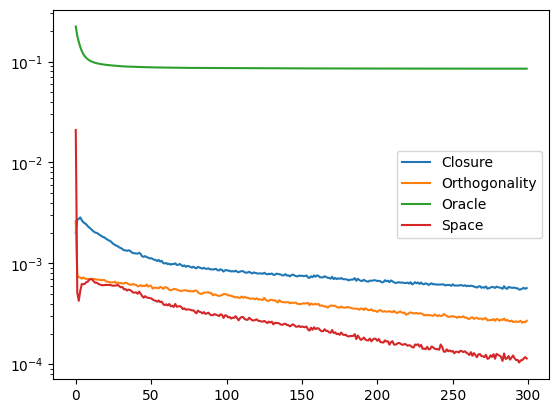

In [12]:
plt.plot(loss_S_closure, label =  "Closure")
plt.plot(loss_S_orth, label =  "Orthogonality")
plt.plot(loss_oracle, label =  "Oracle")
plt.plot(loss_space, label =  "Space")
plt.yscale("log")
plt.legend()

In [13]:
X, Y = next(iter(train_dataloader_Z))
X = X.to(device)
theta = 2*torch.ones(X.shape[0]) - 1 #Sampling
zero = torch.zeros(X.shape[0], device = device)
theta = theta.to(device)


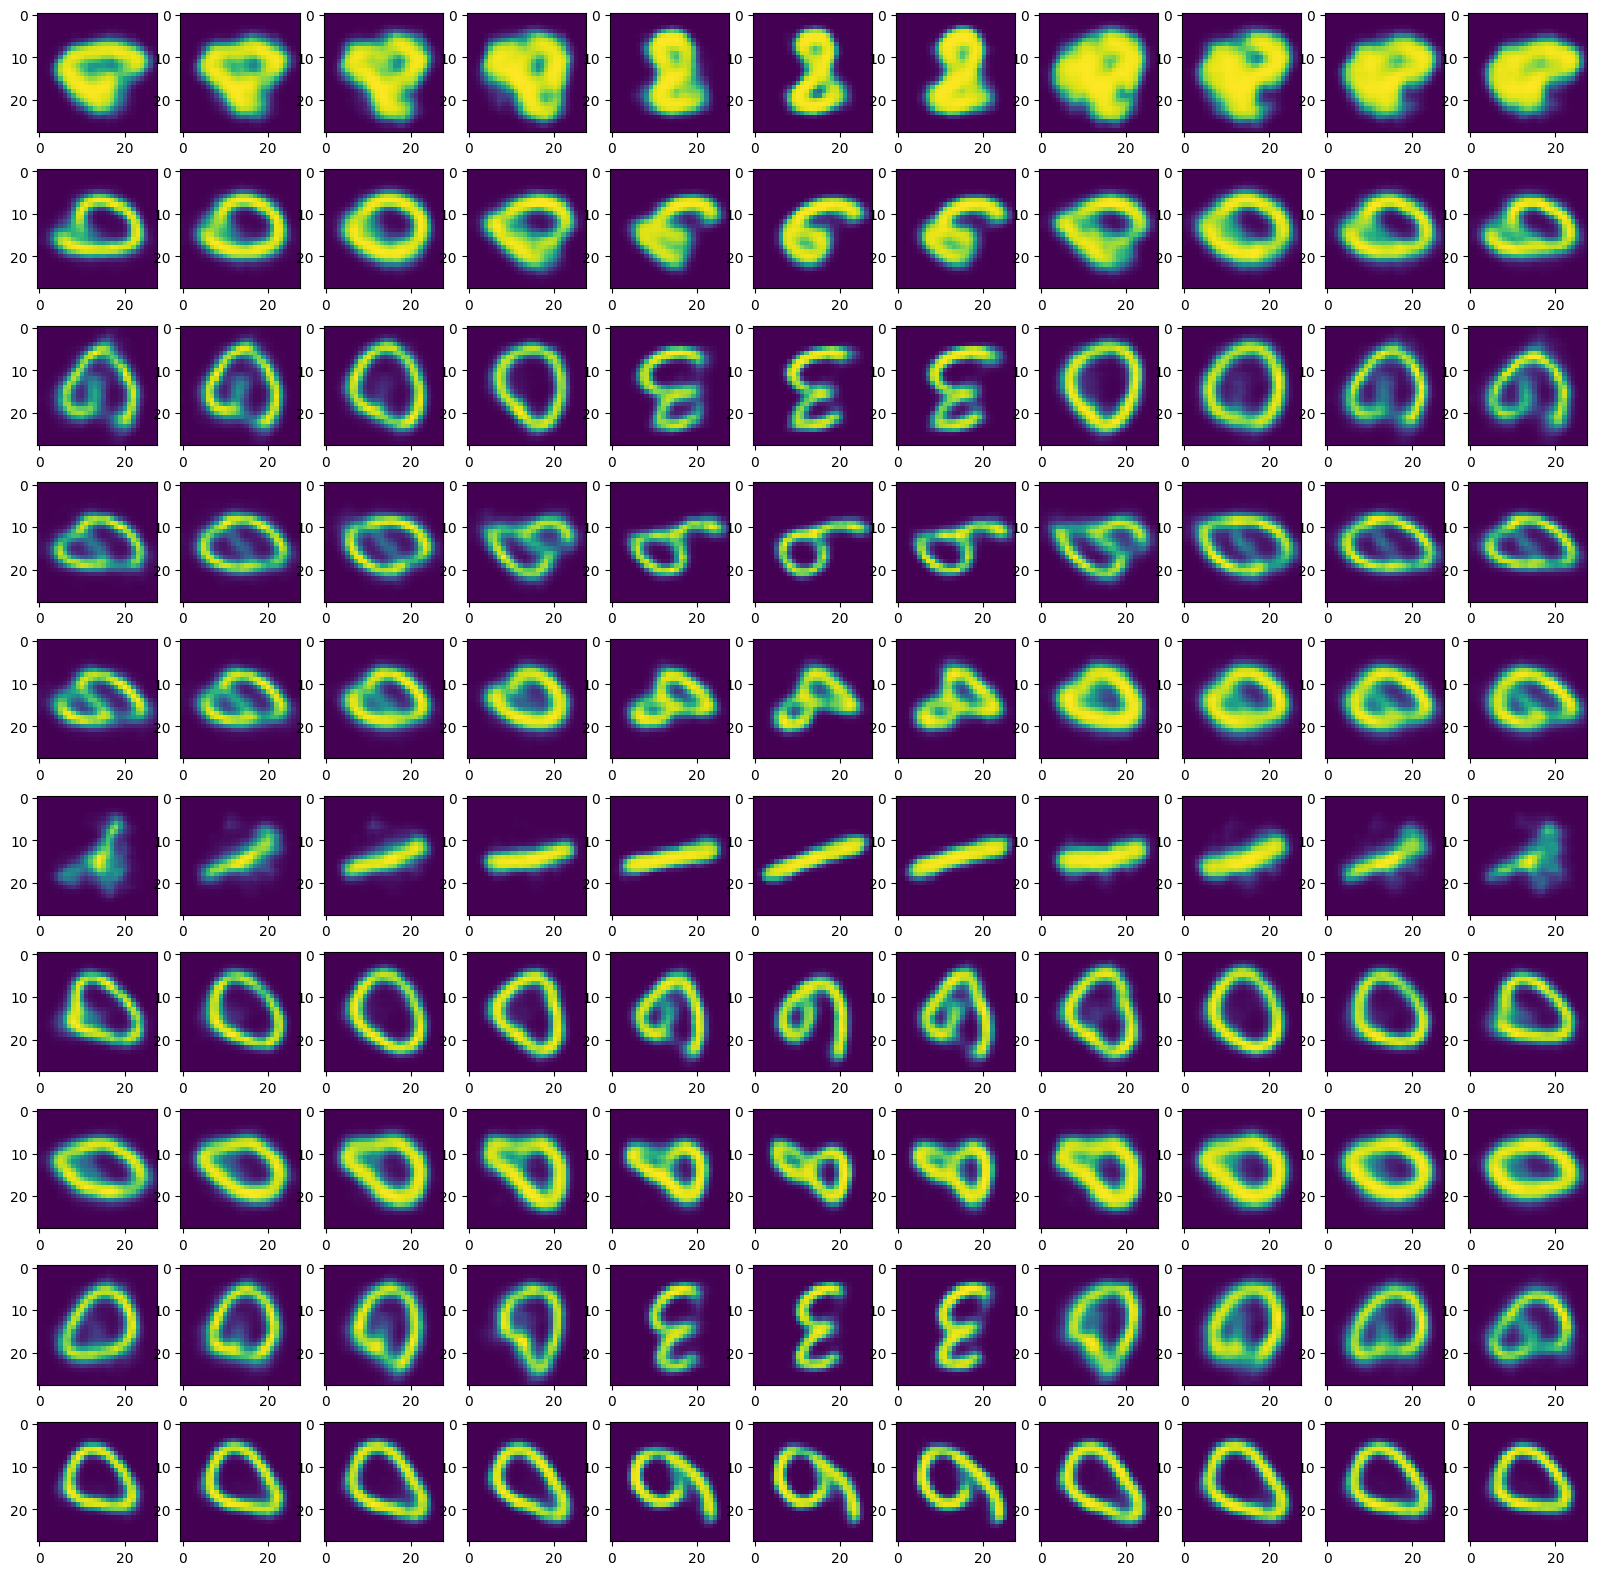

In [14]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([theta*(step),zero,zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

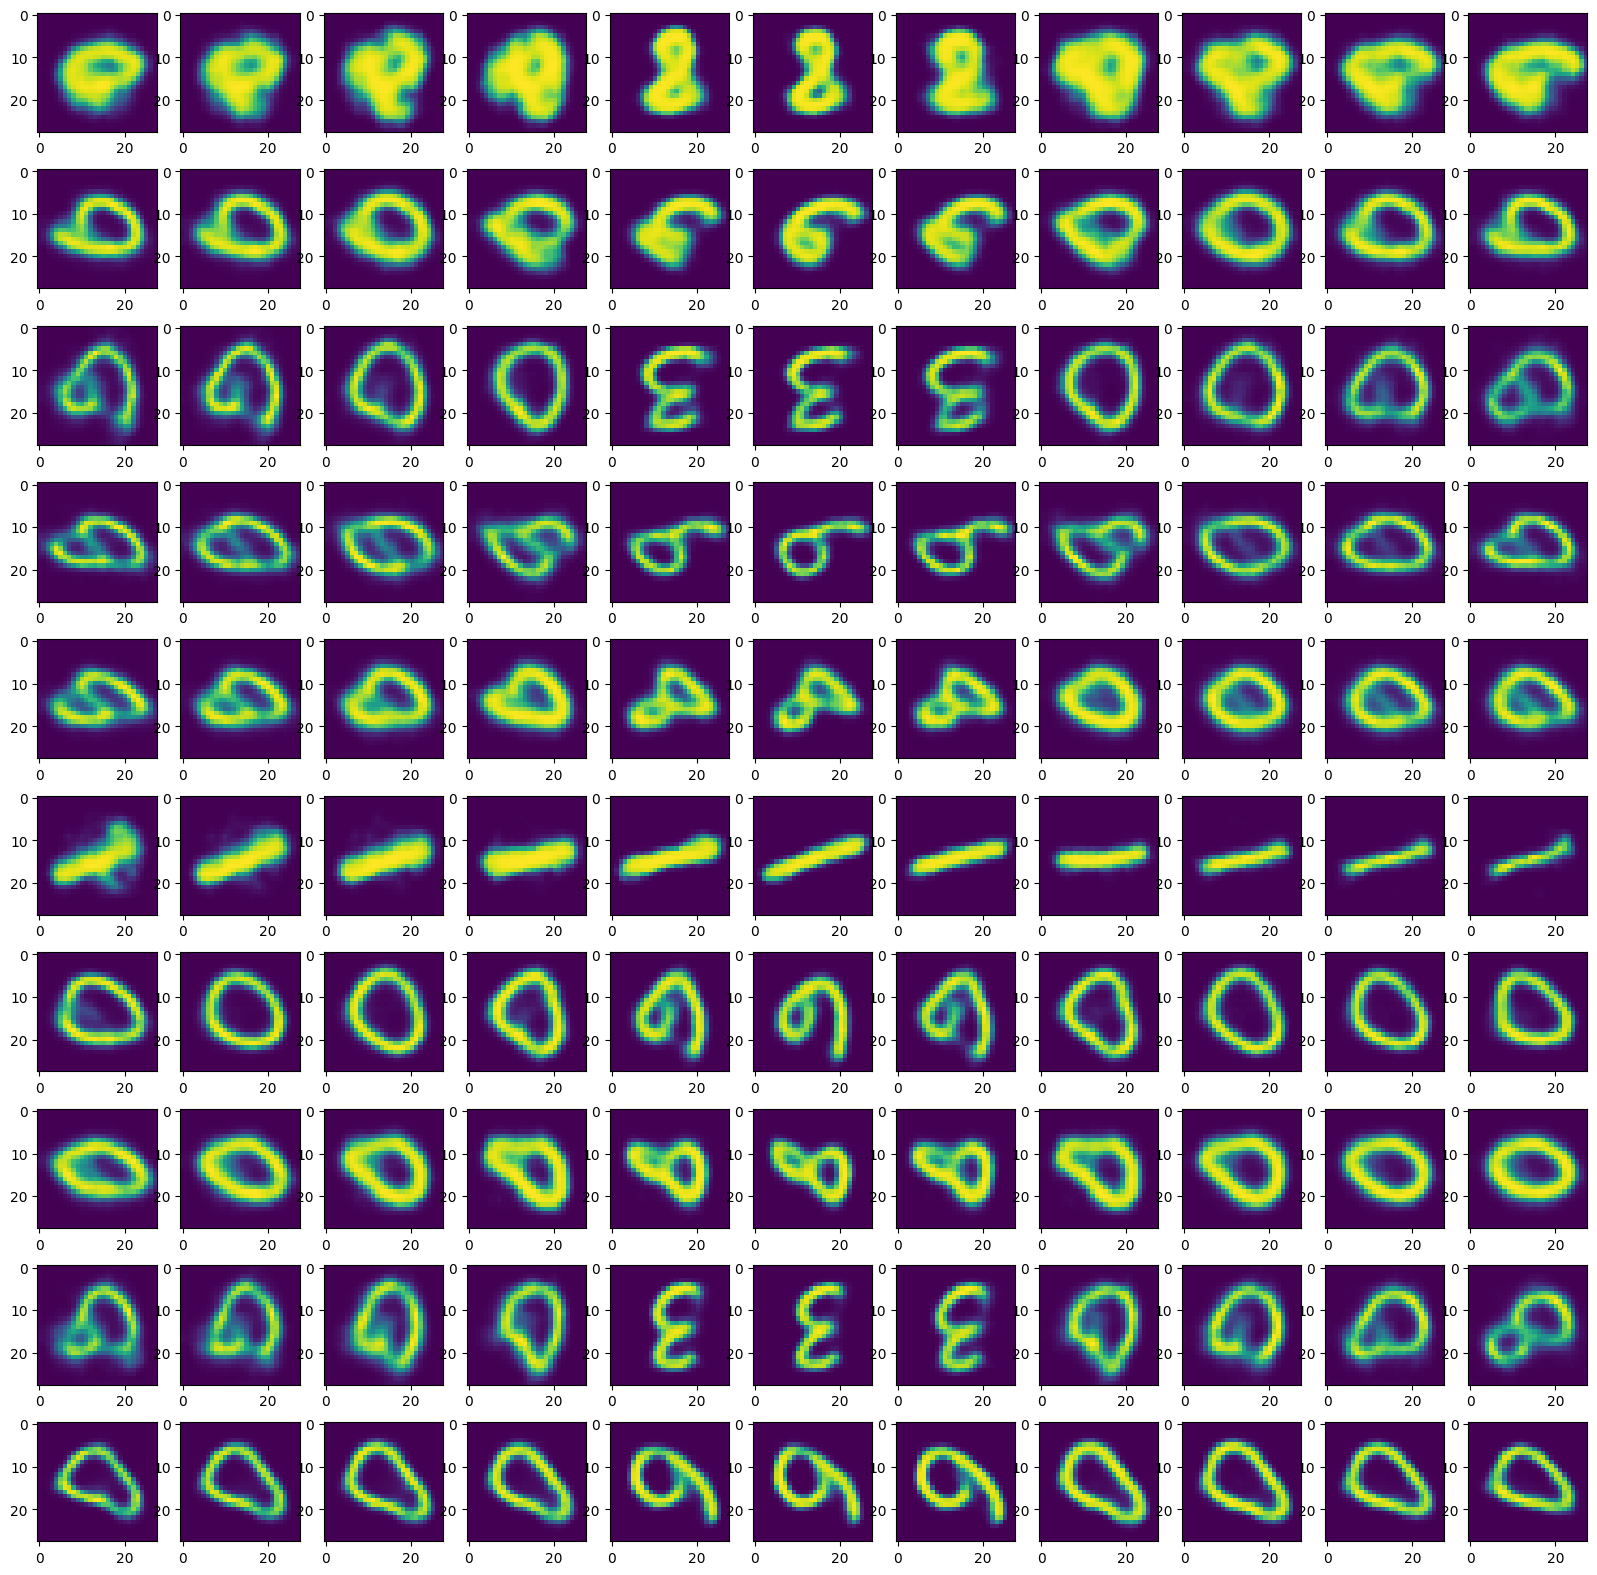

In [15]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([zero,theta*(step),zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

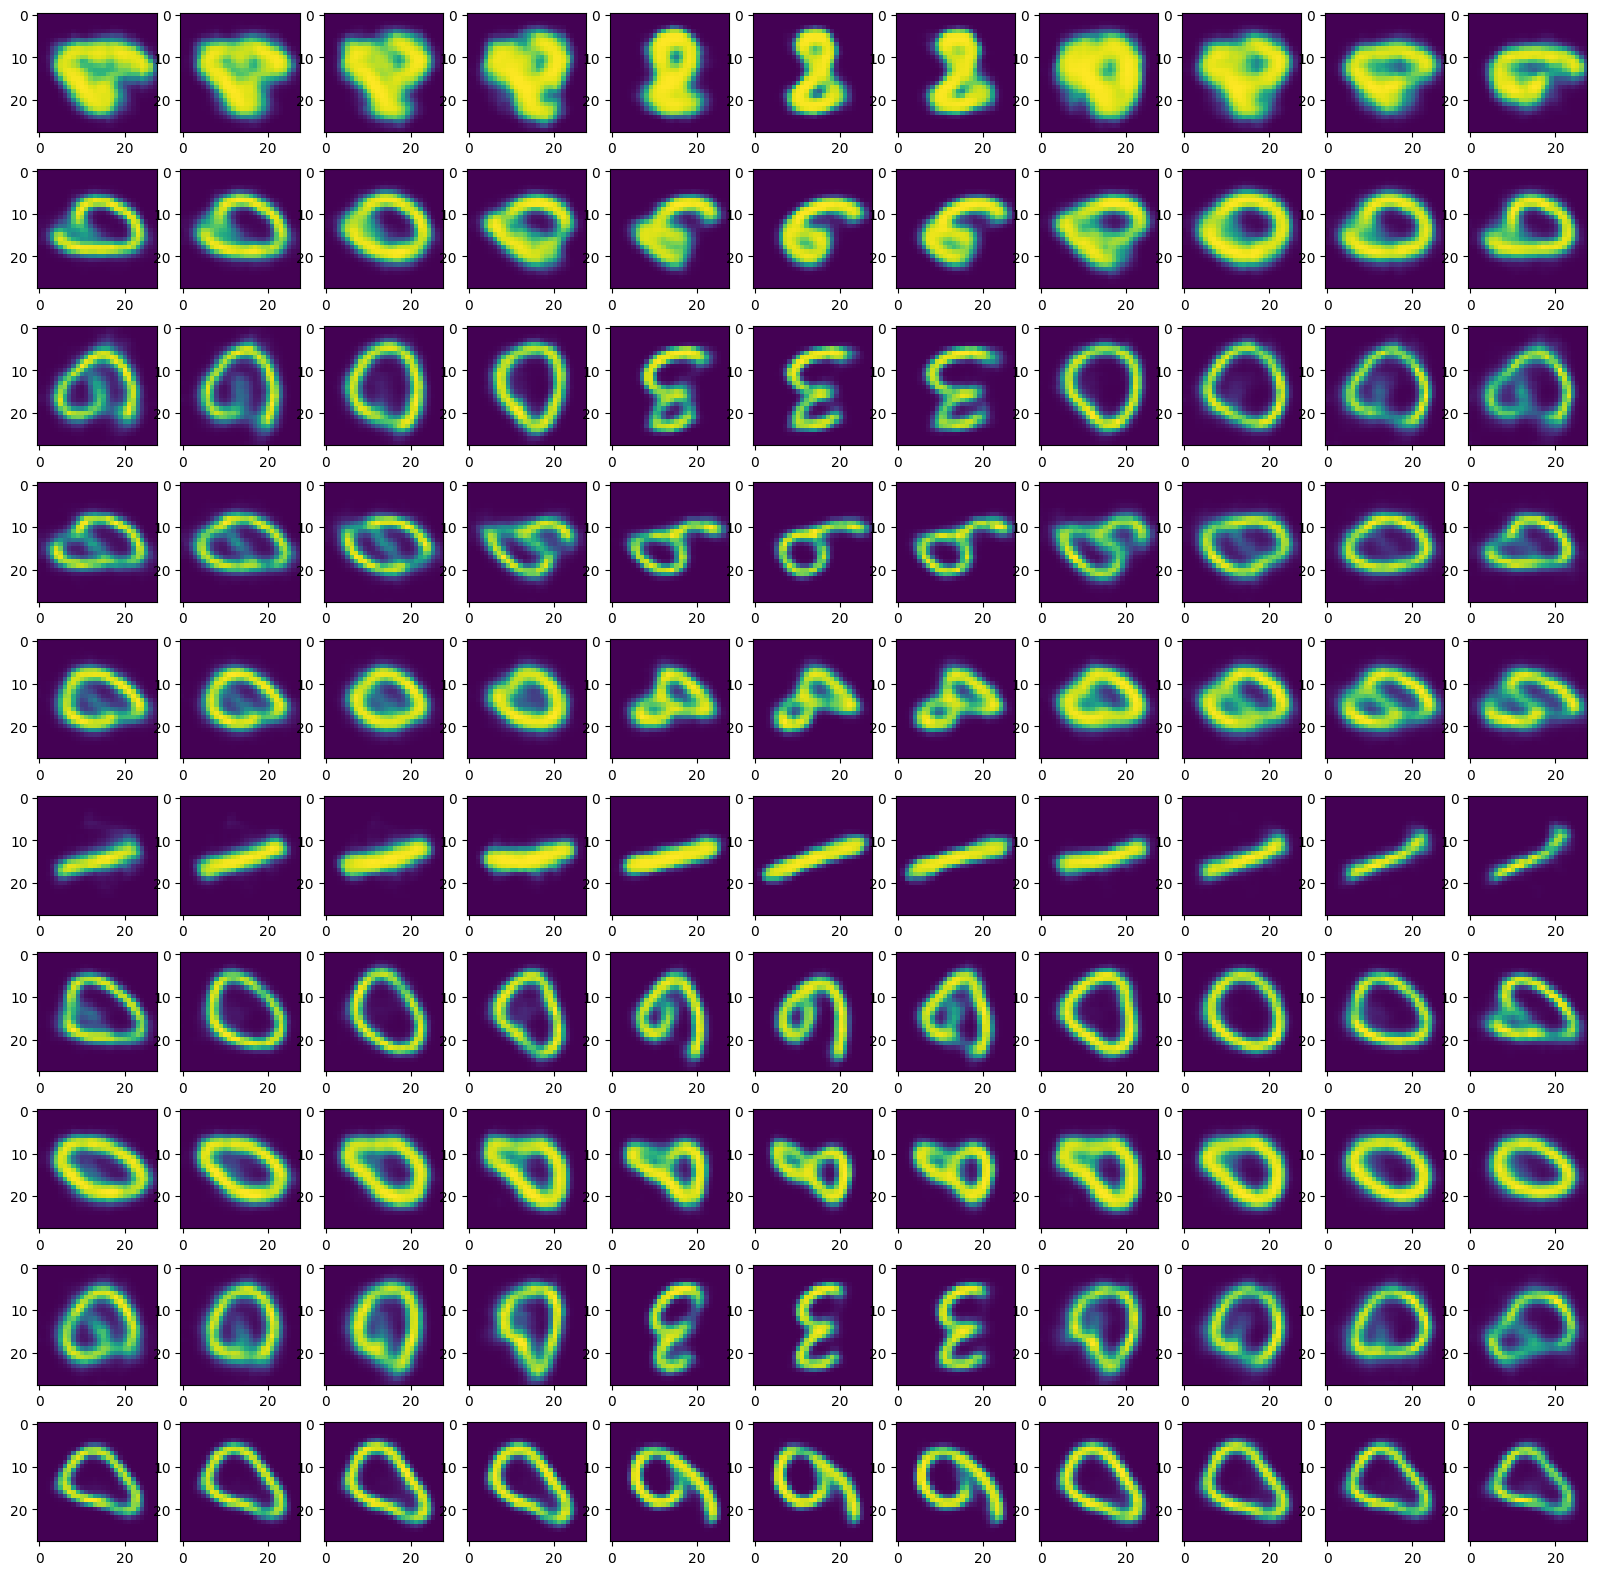

In [16]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([zero,zero,theta*(step)],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

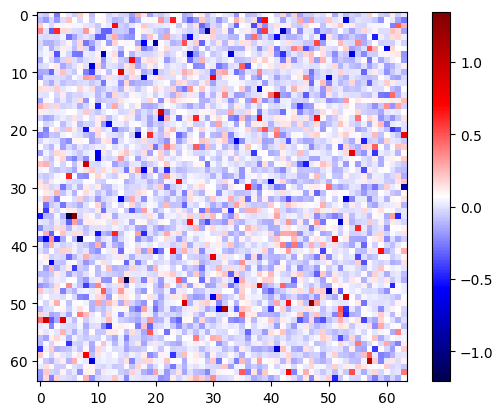

In [17]:
plt.imshow(model_symmetry.group[0].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

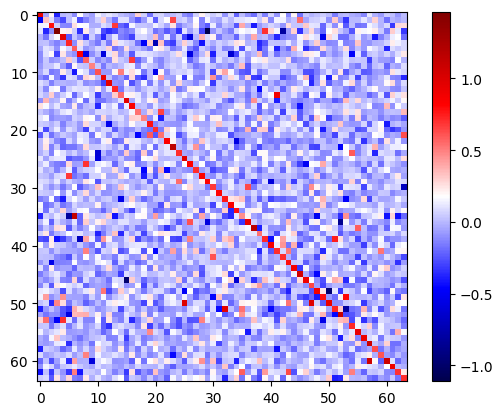

In [18]:
plt.imshow(torch.matrix_exp(model_symmetry.group[0].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()

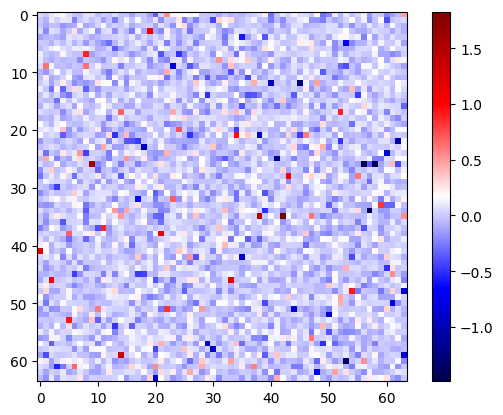

In [19]:
plt.imshow(model_symmetry.group[1].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

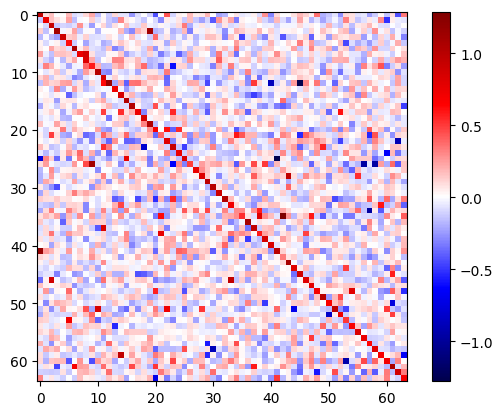

In [20]:
plt.imshow(torch.matrix_exp(model_symmetry.group[1].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()

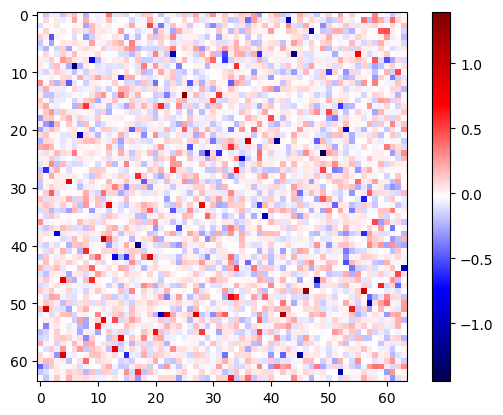

In [21]:
plt.imshow(model_symmetry.group[2].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

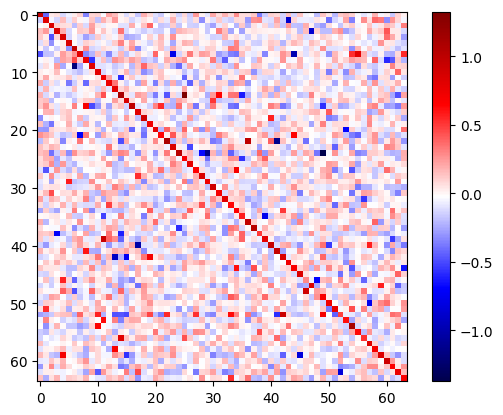

In [22]:
plt.imshow(torch.matrix_exp(model_symmetry.group[2].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()